In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# ==============================================================================
#  الخلية الوحيدة: الإعداد، التعريفات، والتشغيل
# ==============================================================================

# --- 1. الإعداد والتبعيات ---
import os
import sys

# تثبيت المكتبات
!pip install --quiet timm==0.4.12
!pip install --quiet wandb
!pip install laspy[lazrs]
# تنزيل المستودع
CLONED_REPO_NAME = 'InterFuser' # الاسم الأصلي الذي يتم به استنساخ المستودع
REPO_PATH = f'/content/{CLONED_REPO_NAME}'

if not os.path.exists(REPO_PATH):
    print(f"🔍 لم يتم العثور على المستودع. جاري التنزيل من GitHub...")
    !git clone https://github.com/opendilab/InterFuser.git
else:
    print(f"✅ المستودع '{CLONED_REPO_NAME}' موجود بالفعل.")


# --- 2. التصحيح الحاسم: توحيد اسم المجلد وإضافته إلى المسار ---
# إعادة تسمية المجلد من 'InterFuser' إلى 'interfuser' لتجنب مشاكل حالة الأحرف
CORRECT_MODULE_NAME = 'interfuser'
CORRECT_REPO_PATH = f'/content/{CORRECT_MODULE_NAME}'

if os.path.exists(REPO_PATH) and not os.path.exists(CORRECT_REPO_PATH):
    print(f"🔧 إعادة تسمية المجلد من '{CLONED_REPO_NAME}' إلى '{CORRECT_MODULE_NAME}'...")
    os.rename(REPO_PATH, CORRECT_REPO_PATH)

# إضافة المسار الصحيح (بحروف صغيرة) إلى مسار بايثون
if CORRECT_REPO_PATH not in sys.path:
    print(f"🛤️ إضافة المسار '{CORRECT_REPO_PATH}' إلى sys.path...")
    sys.path.append(CORRECT_REPO_PATH)
else:
    print(f"✅ المسار '{CORRECT_REPO_PATH}' موجود بالفعل في sys.path.")

# --- 3. الآن يجب أن تعمل جميع الاستيرادات بنجاح ---
print("\n importing dependencies...")
# ==============================================================================
# سكربت التدريب النهائي: train.py
# ==============================================================================

# --- 1. الاستيراد والتهيئة الأولية ---
import os
import json
import logging
import getpass
from pathlib import Path
from collections import OrderedDict
import torch
import torch.nn as nn
from torch.utils.data import Dataset, Subset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchvision import transforms
import copy
import wandb
import numpy as np
import cv2
import math
from torch.utils.data import Dataset, DataLoader
import json
from torchvision import transforms
from collections import OrderedDict
import logging
import argparse
from tqdm.notebook import tqdm # استخدام نسخة الـ notebook
import random
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from functools import partial
from typing import Optional, List
from torch import Tensor

# استيراد مكونات InterFuser
try:
    from interfuser.timm.models.layers import StdConv2dSame, StdConv2d, to_2tuple
    from interfuser.timm.models.registry import register_model
    from interfuser.timm.models.resnet import resnet26d, resnet34d, resnet50d, resnet18d, resnet26, resnet50, resnet101d
    print("✅ تم استيراد مكونات InterFuser بنجاح!")
except ImportError as e:
    print(f"❌ فشل الاستيراد: {e}")
    print("   - تأكد من أن هيكل المجلدات داخل 'interfuser' صحيح.")

# إعداد TQDM (شريط التقدم) ليعمل في Colab أو بيئة محلية
try:
    if getpass.getuser() == 'root' and 'google.colab' in str(get_ipython()):
        from tqdm.notebook import tqdm
    else:
        from tqdm import tqdm
except NameError:
    from tqdm import tqdm

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


🔍 لم يتم العثور على المستودع. جاري التنزيل من GitHub...
Cloning into 'InterFuser'...
remote: Enumerating objects: 2445, done.
remote: Counting objects: 100% (169/169), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 2445 (delta 64), reused 39 (delta 33), pack-reused 2276 (from 1)
Receiving objects: 100% (2445/2445), 40.00 MiB | 32.08 MiB/s, done.
Resolving deltas: 100% (332/332), done.
✅ المسار '/content/interfuser' موجود بالفعل في sys.path.

 importing dependencies...
✅ تم استيراد مكونات InterFuser بنجاح!


In [ ]:
# ==========================================================
# الخلية 4: تنزيل الملفات بالطريقة المباشرة (بدون list_files)
# ==========================================================
from huggingface_hub import hf_hub_download
import os
import gzip
# معرف المستودع على Hugging Face
REPO_ID = "autonomousvision/PDM_Lite_Carla_LB2"
# نوع المستودع (مجموعة بيانات)
REPO_TYPE = "dataset"
# المجلد المحدد الذي نريد تنزيل الملفات منه
PATH_IN_REPO = "Town01/data"
# المجلد المحلي الذي سيتم حفظ البيانات فيه بعد فك الضغط
LOCAL_DATA_DIR = "PDM_Lite_Carla"

files_to_download = [
    # Town01
    "Town01/data/ControlLoss.zip",
    # "Town01/data/DynamicObjectCrossing.zip",
    # "Town01/data/OppositeVehicleRunningRedLight.zip",
    # "Town01/data/SignalizedJunctionLeftTurn.zip",
    # "Town01/data/SignalizedJunctionRightTurn.zip",
    "Town01/data/VehicleTurningRoute.zip",
    # يمكن إضافة ملفات من Town02, Town03... بنفس الطريقة
    # مثال: "Town02/data/AnotherScenario.zip"
]


print(f"▶️ بدء عملية التنزيل المباشر من المستودع: {REPO_ID}")
print(f"   - سيتم محاولة تنزيل {len(files_to_download)} ملفًا.")

for i, fname in enumerate(files_to_download):
    print(f"\n🔄 [{i+1}/{len(files_to_download)}] بدء تنزيل الملف: {fname}")
    try:
        hf_hub_download(
            repo_id=REPO_ID,
            filename=fname,
            repo_type=REPO_TYPE,
            local_dir=LOCAL_DATA_DIR,
            resume_download=True,
            local_dir_use_symlinks=False,
        )
        print(f"   - ✅ تم تنزيل {fname} بنجاح.")
    except Exception as e:
        # سنقوم بطباعة خطأ أكثر تفصيلاً
        print(f"   - ❌ حدث خطأ أثناء تنزيل {fname}.")
        print(f"   - تفاصيل الخطأ: {e}")

print("\n🎉🎉🎉 اكتملت عملية التنزيل المجدولة! 🎉🎉🎉")

▶️ بدء عملية التنزيل المباشر من المستودع: autonomousvision/PDM_Lite_Carla_LB2
   - سيتم محاولة تنزيل 2 ملفًا.

🔄 [1/2] بدء تنزيل الملف: Town01/data/ControlLoss.zip


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:979: UserWarning: `local_dir_use_symlinks` parameter is deprecated and will be ignored. The process to download files to a loc

Town01/data/ControlLoss.zip:   0%|          | 0.00/435M [00:00<?, ?B/s]

   - ✅ تم تنزيل Town01/data/ControlLoss.zip بنجاح.

🔄 [2/2] بدء تنزيل الملف: Town01/data/VehicleTurningRoute.zip


Town01/data/VehicleTurningRoute.zip:   0%|          | 0.00/2.42G [00:00<?, ?B/s]

   - ✅ تم تنزيل Town01/data/VehicleTurningRoute.zip بنجاح.

🎉🎉🎉 اكتملت عملية التنزيل المجدولة! 🎉🎉🎉


In [ ]:
# # ==========================================================
# # الخلية 4: تنزيل الملفات بالطريقة المباشرة (بدون list_files)
# # ==========================================================
# from huggingface_hub import hf_hub_download
# import os
# import gzip
# # معرف المستودع على Hugging Face
# REPO_ID = "autonomousvision/PDM_Lite_Carla_LB2"
# # نوع المستودع (مجموعة بيانات)
# REPO_TYPE = "dataset"
# # المجلد المحدد الذي نريد تنزيل الملفات منه
# PATH_IN_REPO = "Town01/data"
# # المجلد المحلي الذي سيتم حفظ البيانات فيه بعد فك الضغط
# LOCAL_DATA_DIR = "PDM_Lite_Carla"

# files_to_download = [
#     # Town01
#     # "Town01/data/ControlLoss.zip",
#     # "Town01/data/DynamicObjectCrossing.zip",
#     # "Town01/data/OppositeVehicleRunningRedLight.zip",
#     # "Town01/data/SignalizedJunctionLeftTurn.zip",
#     # "Town01/data/SignalizedJunctionRightTurn.zip",
# #     "Town01/data/VehicleTurningRoute.zip",
# # #
# #     # "Town01/data/Accident.zip"
# # "Town13/data/Accident.zip",
# # # AccidentTwoWays.zip
# # "Town13/data/AccidentTwoWays.zip",

# # BlockedIntersection.zip
# "Town13/data/BlockedIntersection.zip",
# # ConstructionObstacle.zip
# "Town13/data/ConstructionObstacle.zip",
# # ConstructionObstacleTwoWays.zip
# "Town13/data/ConstructionObstacleTwoWays.zip",
# # ControlLoss.zip
# "Town13/data/ControlLoss.zip",
# # DynamicObjectCrossing.zip
# "Town13/data/DynamicObjectCrossing.zip",
# # EnterActorFlow.zip
# "Town13/data/EnterActorFlow.zip",
# # HardBreakRoute.zip
# "Town13/data/HardBreakRoute.zip",
# # HazardAtSideLane.zip
# "Town13/data/HazardAtSideLane.zip",
# # HazardAtSideLaneTwoWays.zip
# "Town13/data/HazardAtSideLaneTwoWays.zip",
# # HighwayCutIn.zip
# # "Town13/data/HighwayCutIn.zip",
# # HighwayExit.zip
# "Town13/data/HighwayExit.zip",
# # InterurbanActorFlow.zip
# "Town13/data/InterurbanActorFlow.zip",
# # InterurbanAdvancedActorFlow.zip
# "Town13/data/InterurbanAdvancedActorFlow.zip",
# # InvadingTurn.zip
# "Town13/data/InvadingTurn.zip",
# # MergerIntoSlowTraffic.zip
# "Town13/data/MergerIntoSlowTraffic.zip",
# # MergerIntoSlowTrafficV2.zip
# "Town13/data/MergerIntoSlowTrafficV2.zip",
# # NonSignalizedJunctionLeftTurn.zip
# "Town13/data/NonSignalizedJunctionLeftTurn.zip",
# # NonSignalizedJunctionRightTurn.zip
# "Town13/data/NonSignalizedJunctionRightTurn.zip",
# # OppositeVehicleRunningRedLight.zip
# "Town13/data/OppositeVehicleRunningRedLight.zip",
# # OppositeVehicleTakingPriority.zip
# "Town13/data/OppositeVehicleTakingPriority.zip",
# # ParkedObstacle.zip
# # "Town13/data/ParkedObstacle.zip",
# # ParkedObstacleTwoWays.zip
# # "Town13/data/ParkedObstacleTwoWays.zip",
# # # ParkingCrossingPedestrian.zip
# # "Town13/data/ParkingCrossingPedestrian.zip",
# # # ParkingCutIn.zip
# # "Town13/data/ParkingCutIn.zip",
# # ParkingExit.zip
# # "Town13/data/ParkingExit.zip",
# # # PedestrianCrossing.zip
# # "Town13/data/PedestrianCrossing.zip",
# # # PriorityAtJunction.zip
# # "Town13/data/PriorityAtJunction.zip",
# # # SignalizedJunctionLeftTurn.zip
# # "Town13/data/SignalizedJunctionLeftTurn.zip",
# # # SignalizedJunctionRightTurn.zip
# # "Town13/data/SignalizedJunctionRightTurn.zip",
# # # StaticCutIn.zip
# # "Town13/data/StaticCutIn.zip",
# # # VehicleOpensDoorTwoWays.zip
# # "Town13/data/VehicleOpensDoorTwoWays.zip",
# # # VehicleTurningRoute.zip
# # "Town13/data/VehicleTurningRoute.zip",
# # # VehicleTurningRoutePedestrian.zip
# # "Town13/data/VehicleTurningRoutePedestrian.zip",
# # # YieldToEmergencyVehicle.zip
# # "Town13/data/YieldToEmergencyVehicle.zip",
# ]


# print(f"▶️ بدء عملية التنزيل المباشر من المستودع: {REPO_ID}")
# print(f"   - سيتم محاولة تنزيل {len(files_to_download)} ملفًا.")

# for i, fname in enumerate(files_to_download):
#     print(f"\n🔄 [{i+1}/{len(files_to_download)}] بدء تنزيل الملف: {fname}")
#     try:
#         hf_hub_download(
#             repo_id=REPO_ID,
#             filename=fname,
#             repo_type=REPO_TYPE,
#             local_dir=LOCAL_DATA_DIR,
#             resume_download=True,
#             local_dir_use_symlinks=False,
#         )
#         print(f"   - ✅ تم تنزيل {fname} بنجاح.")
#     except Exception as e:
#         # سنقوم بطباعة خطأ أكثر تفصيلاً
#         print(f"   - ❌ حدث خطأ أثناء تنزيل {fname}.")
#         print(f"   - تفاصيل الخطأ: {e}")

# print("\n🎉🎉🎉 اكتملت عملية التنزيل المجدولة! 🎉🎉🎉")

In [ ]:
import os
import zipfile

# مسار مجلد البيانات
data_dir = "/content/PDM_Lite_Carla/Town01/data"

# البحث عن كل ملفات ZIP داخل المجلد
for file in os.listdir(data_dir):
    if file.endswith(".zip"):
        zip_path = os.path.join(data_dir, file)
        print(f"📦 فك الضغط: {zip_path}")

        # فك الضغط في نفس المجلد
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(data_dir)

        # حذف الملف بعد فك الضغط
        os.remove(zip_path)
        print(f"🗑️ تم حذف: {zip_path}")

print("✅ تم فك الضغط لجميع الملفات وحذف ملفات ZIP بنجاح!")


📦 فك الضغط: /content/PDM_Lite_Carla/Town01/data/VehicleTurningRoute.zip
🗑️ تم حذف: /content/PDM_Lite_Carla/Town01/data/VehicleTurningRoute.zip
📦 فك الضغط: /content/PDM_Lite_Carla/Town01/data/ControlLoss.zip
🗑️ تم حذف: /content/PDM_Lite_Carla/Town01/data/ControlLoss.zip
✅ تم فك الضغط لجميع الملفات وحذف ملفات ZIP بنجاح!


In [ ]:
# import os
# import zipfile

# # مسار مجلد البيانات
# data_dir = "/content/PDM_Lite_Carla/Town13/data"

# # البحث عن كل ملفات ZIP داخل المجلد
# for file in os.listdir(data_dir):
#     if file.endswith(".zip"):
#         zip_path = os.path.join(data_dir, file)
#         print(f"📦 فك الضغط: {zip_path}")

#         # فك الضغط في نفس المجلد
#         with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#             zip_ref.extractall(data_dir)

#         # حذف الملف بعد فك الضغط
#         os.remove(zip_path)
#         print(f"🗑️ تم حذف: {zip_path}")

# print("✅ تم فك الضغط لجميع الملفات وحذف ملفات ZIP بنجاح!")


In [ ]:
#المفتاح الخاص بك


In [ ]:
wandb.login()

True

In [ ]:

class HybridEmbed(nn.Module):
    def __init__(
        self,
        backbone,
        img_size=224,
        patch_size=1,
        feature_size=None,
        in_chans=3,
        embed_dim=768,
    ):
        super().__init__()
        assert isinstance(backbone, nn.Module)
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        self.img_size = img_size
        self.patch_size = patch_size
        self.backbone = backbone
        if feature_size is None:
            with torch.no_grad():
                training = backbone.training
                if training:
                    backbone.eval()
                o = self.backbone(torch.zeros(1, in_chans, img_size[0], img_size[1]))
                if isinstance(o, (list, tuple)):
                    o = o[-1]  # last feature if backbone outputs list/tuple of features
                feature_size = o.shape[-2:]
                feature_dim = o.shape[1]
                backbone.train(training)
        else:
            feature_size = to_2tuple(feature_size)
            if hasattr(self.backbone, "feature_info"):
                feature_dim = self.backbone.feature_info.channels()[-1]
            else:
                feature_dim = self.backbone.num_features

        self.proj = nn.Conv2d(feature_dim, embed_dim, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.backbone(x)
        if isinstance(x, (list, tuple)):
            x = x[-1]  # last feature if backbone outputs list/tuple of features
        x = self.proj(x)
        global_x = torch.mean(x, [2, 3], keepdim=False)[:, :, None]
        return x, global_x


class PositionEmbeddingSine(nn.Module):
    """
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    """

    def __init__(
        self, num_pos_feats=64, temperature=10000, normalize=False, scale=None
    ):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, tensor):
        x = tensor
        bs, _, h, w = x.shape
        not_mask = torch.ones((bs, h, w), device=x.device)
        y_embed = not_mask.cumsum(1, dtype=torch.float32)
        x_embed = not_mask.cumsum(2, dtype=torch.float32)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (y_embed[:, -1:, :] + eps) * self.scale
            x_embed = x_embed / (x_embed[:, :, -1:] + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed[:, :, :, None] / dim_t
        pos_y = y_embed[:, :, :, None] / dim_t
        pos_x = torch.stack(
            (pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4
        ).flatten(3)
        pos_y = torch.stack(
            (pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4
        ).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos

import torch
import torch.nn as nn
import math

class HyperDimensionalPositionalEncoding(nn.Module):
    """
    [HDPE - Paper-Aligned Implementation]
    A novel positional encoding based on the geometric properties of high-dimensional spaces.

    This module generates a content-agnostic prior by creating a center-aware
    attentional anchor. It transforms Cartesian coordinates into a polar
    representation (Radius R, Angle Theta), encodes them using multi-frequency
    sinusoidal functions, and modulates them with a Gaussian saliency mask.
    """
    def __init__(self, num_pos_feats=256, temperature=10000, gaussian_sigma=1.0, normalize=False, scale=None):
        """
        Args:
            num_pos_feats (int): The total number of output channels. Must be divisible by 4.
            temperature (int): A scaling factor for the sinusoidal frequencies.
            gaussian_sigma (float): The standard deviation (σ) of the Gaussian saliency mask.
                                    Controls the spatial extent of the central prior.
            normalize (bool): If True, normalizes coordinates before processing.
            scale (float, optional): The scaling factor for normalization. Defaults to 2*pi.
        """
        super().__init__()

        if num_pos_feats % 4 != 0:
            raise ValueError(f"num_pos_feats must be divisible by 4, but got {num_pos_feats}")

        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.sigma = gaussian_sigma
        self.normalize = normalize

        if scale is not None and not normalize:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            scale = 2 * math.pi
        self.scale = scale

        # K: Number of frequency pairs for EACH of R and Theta
        # Total channels will be 4 * K
        self.num_freq_pairs = num_pos_feats // 4

    def forward(self, tensor: torch.Tensor) -> torch.Tensor:
        """
        Args:
            tensor (torch.Tensor): A 4D tensor of shape (B, C, H, W). The content is not
                                   used, only its shape and device.

        Returns:
            torch.Tensor: A 4D tensor of positional encodings with shape (B, num_pos_feats, H, W).
        """
        batch_size, _, h, w = tensor.shape
        device = tensor.device

        # 1. Create normalized coordinate grid [-1, 1]
        # This matches the mathematical formulation in the paper
        y_embed = torch.linspace(-1, 1, h, dtype=torch.float32, device=device)
        x_embed = torch.linspace(-1, 1, w, dtype=torch.float32, device=device)
        y_grid, x_grid = torch.meshgrid(y_embed, x_embed, indexing='ij')

        # 2. Convert to Polar Coordinates (R, θ)
        # R: Radius (Euclidean distance from the center [0,0])
        # θ: Angle (atan2)
        radius = torch.sqrt(x_grid**2 + y_grid**2)
        theta = torch.atan2(y_grid, x_grid)

        # 3. Compute Gaussian Saliency Mask (S)
        # S = exp(-(R/σ)^2)
        saliency_mask = torch.exp(-(radius**2) / (self.sigma**2))

        # 4. Create multi-frequency sinusoidal encodings
        dim_t = torch.arange(self.num_freq_pairs, dtype=torch.float32, device=device)
        # The paper uses f_k = 2^k, which is aggressive. The standard Transformer
        # uses a geometric progression which is more stable. We stick to the
        # standard Transformer's frequency scaling for better training stability.
        freqs = self.temperature ** (2 * dim_t / self.num_freq_pairs)

        # Create encodings for Radius (R)
        pos_r = radius.unsqueeze(-1) / freqs
        pos_r_sin = pos_r.sin()
        pos_r_cos = pos_r.cos()

        # Create encodings for Angle (θ)
        pos_theta = theta.unsqueeze(-1) / freqs
        pos_theta_sin = pos_theta.sin()
        pos_theta_cos = pos_theta.cos()

        # 5. Modulate with the Gaussian Saliency Mask
        # This is the key step of HDPE
        pos_r_sin = pos_r_sin * saliency_mask.unsqueeze(-1)
        pos_r_cos = pos_r_cos * saliency_mask.unsqueeze(-1)
        pos_theta_sin = pos_theta_sin * saliency_mask.unsqueeze(-1)
        pos_theta_cos = pos_theta_cos * saliency_mask.unsqueeze(-1)

        # 6. Concatenate and reshape to the desired output format (B, C, H, W)
        pos_encoding = torch.cat(
            [pos_r_sin, pos_r_cos, pos_theta_sin, pos_theta_cos], dim=-1
        )
        pos_encoding = pos_encoding.permute(2, 0, 1).unsqueeze(0).repeat(batch_size, 1, 1, 1)

        return pos_encoding

# class HyperDimensionalPositionalEncoding(nn.Module):
#     """
#     [GCPE v1.1 - Professional & Corrected Implementation]
#     A novel positional encoding scheme based on geometric centrality.

#     This class is designed as a drop-in replacement for the standard
#     PositionEmbeddingSine, accepting similar arguments and producing an
#     output of the same shape. This version corrects a type error in the
#     distance calculation.
#     """
#     def __init__(self, num_pos_feats=256, temperature=10000, normalize=True, scale=None):
#         """
#         Args:
#             num_pos_feats (int): The desired number of output channels for the positional encoding.
#                                  This must be an even number.
#             temperature (int): A constant used to scale the frequencies.
#             normalize (bool): If True, normalizes the coordinates to the range [0, scale].
#             scale (float, optional): The scaling factor for normalization. Defaults to 2*pi.
#         """
#         super().__init__()

#         if num_pos_feats % 2 != 0:
#             raise ValueError(f"num_pos_feats must be an even number, but got {num_pos_feats}")

#         self.num_pos_feats = num_pos_feats
#         self.temperature = temperature
#         self.normalize = normalize

#         if scale is not None and not normalize:
#             raise ValueError("normalize should be True if scale is passed")
#         if scale is None:
#             scale = 2 * math.pi
#         self.scale = scale

#     def forward(self, tensor: torch.Tensor) -> torch.Tensor:
#         """
#         Args:
#             tensor (torch.Tensor): A 4D tensor of shape (B, C, H, W). The content is not
#                                    used, only its shape and device.

#         Returns:
#             torch.Tensor: A 4D tensor of positional encodings with shape (B, num_pos_feats, H, W).
#         """
#         batch_size, _, h, w = tensor.shape
#         device = tensor.device

#         # 1. Create coordinate grids
#         y_embed = torch.arange(h, dtype=torch.float32, device=device).view(h, 1)
#         x_embed = torch.arange(w, dtype=torch.float32, device=device).view(1, w)

#         # 2. Calculate normalized distance from the center
#         # Use floating point division for center calculation
#         center_y, center_x = (h - 1) / 2.0, (w - 1) / 2.0

#         # Calculate the Euclidean distance for each pixel from the center
#         dist_map = torch.sqrt(
#             (y_embed - center_y)**2 + (x_embed - center_x)**2
#         )

#         # ✅ CORRECTION: The max distance is a scalar, no need for torch.sqrt on a float.
#         # We can calculate it with math.sqrt or just compute the squared value.
#         # To keep everything in tensors for consistency, we can do this:
#         max_dist_sq = torch.tensor(center_y**2 + center_x**2, device=device)
#         max_dist = torch.sqrt(max_dist_sq)

#         # Normalize the distance map to the range [0, 1]
#         normalized_dist_map = dist_map / (max_dist + 1e-6)

#         if self.normalize:
#             normalized_dist_map = normalized_dist_map * self.scale

#         pos_dist = normalized_dist_map.unsqueeze(0).repeat(batch_size, 1, 1)

#         # 3. Create the frequency-based embedding
#         # This part remains the same as it operates on tensors correctly.
#         dim_t = torch.arange(self.num_pos_feats // 2, dtype=torch.float32, device=device)
#         dim_t = self.temperature ** (2 * dim_t / (self.num_pos_feats // 2))

#         pos = pos_dist.unsqueeze(-1) / dim_t

#         pos_sin = pos.sin()
#         pos_cos = pos.cos()

#         # 4. Concatenate and reshape to match the desired output format
#         pos = torch.cat((pos_sin, pos_cos), dim=3)
#         pos = pos.permute(0, 3, 1, 2)

#         return pos

class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers, norm=None):
        super().__init__()
        self.layers = _get_clones(encoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm

    def forward(
        self,
        src,
        mask: Optional[Tensor] = None,
        src_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
    ):
        output = src

        for layer in self.layers:
            output = layer(
                output,
                src_mask=mask,
                src_key_padding_mask=src_key_padding_mask,
                pos=pos,
            )

        if self.norm is not None:
            output = self.norm(output)

        return output


class SpatialSoftmax(nn.Module):
    def __init__(self, height, width, channel, temperature=None, data_format="NCHW"):
        super().__init__()

        self.data_format = data_format
        self.height = height
        self.width = width
        self.channel = channel

        if temperature:
            self.temperature = Parameter(torch.ones(1) * temperature)
        else:
            self.temperature = 1.0

        pos_x, pos_y = np.meshgrid(
            np.linspace(-1.0, 1.0, self.height), np.linspace(-1.0, 1.0, self.width)
        )
        pos_x = torch.from_numpy(pos_x.reshape(self.height * self.width)).float()
        pos_y = torch.from_numpy(pos_y.reshape(self.height * self.width)).float()
        self.register_buffer("pos_x", pos_x)
        self.register_buffer("pos_y", pos_y)

    def forward(self, feature):
        # Output:
        #   (N, C*2) x_0 y_0 ...

        if self.data_format == "NHWC":
            feature = (
                feature.transpose(1, 3)
                .tranpose(2, 3)
                .view(-1, self.height * self.width)
            )
        else:
            feature = feature.view(-1, self.height * self.width)

        weight = F.softmax(feature / self.temperature, dim=-1)
        expected_x = torch.sum(
            torch.autograd.Variable(self.pos_x) * weight, dim=1, keepdim=True
        )
        expected_y = torch.sum(
            torch.autograd.Variable(self.pos_y) * weight, dim=1, keepdim=True
        )
        expected_xy = torch.cat([expected_x, expected_y], 1)
        feature_keypoints = expected_xy.view(-1, self.channel, 2)
        feature_keypoints[:, :, 1] = (feature_keypoints[:, :, 1] - 1) * 12
        feature_keypoints[:, :, 0] = feature_keypoints[:, :, 0] * 12
        return feature_keypoints


class MultiPath_Generator(nn.Module):
    def __init__(self, in_channel, embed_dim, out_channel):
        super().__init__()
        self.spatial_softmax = SpatialSoftmax(100, 100, out_channel)
        self.tconv0 = nn.Sequential(
            nn.ConvTranspose2d(in_channel, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.tconv1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
        )
        self.tconv2 = nn.Sequential(
            nn.ConvTranspose2d(256, 192, 4, 2, 1, bias=False),
            nn.BatchNorm2d(192),
            nn.ReLU(True),
        )
        self.tconv3 = nn.Sequential(
            nn.ConvTranspose2d(192, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
        )
        self.tconv4_list = torch.nn.ModuleList(
            [
                nn.Sequential(
                    nn.ConvTranspose2d(64, out_channel, 8, 2, 3, bias=False),
                    nn.Tanh(),
                )
                for _ in range(6)
            ]
        )

        self.upsample = nn.Upsample(size=(50, 50), mode="bilinear")

    def forward(self, x, measurements):
        mask = measurements[:, :6]
        mask = mask.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).repeat(1, 1, 1, 100, 100)
        velocity = measurements[:, 6:7].unsqueeze(-1).unsqueeze(-1)
        velocity = velocity.repeat(1, 32, 2, 2)

        n, d, c = x.shape
        x = x.transpose(1, 2)
        x = x.view(n, -1, 2, 2)
        x = torch.cat([x, velocity], dim=1)
        x = self.tconv0(x)
        x = self.tconv1(x)
        x = self.tconv2(x)
        x = self.tconv3(x)
        x = self.upsample(x)
        xs = []
        for i in range(6):
            xt = self.tconv4_list[i](x)
            xs.append(xt)
        xs = torch.stack(xs, dim=1)
        x = torch.sum(xs * mask, dim=1)
        x = self.spatial_softmax(x)
        return x


class LinearWaypointsPredictor(nn.Module):
    def __init__(self, input_dim, cumsum=True):
        super().__init__()
        self.cumsum = cumsum
        self.rank_embed = nn.Parameter(torch.zeros(1, 10, input_dim))
        self.head_fc1_list = nn.ModuleList([nn.Linear(input_dim, 64) for _ in range(6)])
        self.head_relu = nn.ReLU(inplace=True)
        self.head_fc2_list = nn.ModuleList([nn.Linear(64, 2) for _ in range(6)])

    def forward(self, x, measurements):
        # input shape: n 10 embed_dim
        bs, n, dim = x.shape
        x = x + self.rank_embed
        x = x.reshape(-1, dim)

        mask = measurements[:, :6]
        mask = torch.unsqueeze(mask, -1).repeat(n, 1, 2)

        rs = []
        for i in range(6):
            res = self.head_fc1_list[i](x)
            res = self.head_relu(res)
            res = self.head_fc2_list[i](res)
            rs.append(res)
        rs = torch.stack(rs, 1)
        x = torch.sum(rs * mask, dim=1)

        x = x.view(bs, n, 2)
        if self.cumsum:
            x = torch.cumsum(x, 1)
        return x


class GRUWaypointsPredictor(nn.Module):
    def __init__(self, input_dim, waypoints=10):
        super().__init__()
        # self.gru = torch.nn.GRUCell(input_size=input_dim, hidden_size=64)
        self.gru = torch.nn.GRU(input_size=input_dim, hidden_size=64, batch_first=True)
        self.encoder = nn.Linear(2, 64)
        self.decoder = nn.Linear(64, 2)
        self.waypoints = waypoints

    def forward(self, x, target_point):
        bs = x.shape[0]
        z = self.encoder(target_point).unsqueeze(0)
        output, _ = self.gru(x, z)
        output = output.reshape(bs * self.waypoints, -1)
        output = self.decoder(output).reshape(bs, self.waypoints, 2)
        output = torch.cumsum(output, 1)
        return output

class GRUWaypointsPredictorWithCommand(nn.Module):
    def __init__(self, input_dim, waypoints=10):
        super().__init__()
        # self.gru = torch.nn.GRUCell(input_size=input_dim, hidden_size=64)
        self.grus = nn.ModuleList([torch.nn.GRU(input_size=input_dim, hidden_size=64, batch_first=True) for _ in range(6)])
        self.encoder = nn.Linear(2, 64)
        self.decoders = nn.ModuleList([nn.Linear(64, 2) for _ in range(6)])
        self.waypoints = waypoints

    def forward(self, x, target_point, measurements):
        bs, n, dim = x.shape
        mask = measurements[:, :6, None, None]
        mask = mask.repeat(1, 1, self.waypoints, 2)

        z = self.encoder(target_point).unsqueeze(0)
        outputs = []
        for i in range(6):
            output, _ = self.grus[i](x, z)
            output = output.reshape(bs * self.waypoints, -1)
            output = self.decoders[i](output).reshape(bs, self.waypoints, 2)
            output = torch.cumsum(output, 1)
            outputs.append(output)
        outputs = torch.stack(outputs, 1)
        output = torch.sum(outputs * mask, dim=1)
        return output


class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers, norm=None, return_intermediate=False):
        super().__init__()
        self.layers = _get_clones(decoder_layer, num_layers)
        self.num_layers = num_layers
        self.norm = norm
        self.return_intermediate = return_intermediate

    def forward(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        output = tgt

        intermediate = []

        for layer in self.layers:
            output = layer(
                output,
                memory,
                tgt_mask=tgt_mask,
                memory_mask=memory_mask,
                tgt_key_padding_mask=tgt_key_padding_mask,
                memory_key_padding_mask=memory_key_padding_mask,
                pos=pos,
                query_pos=query_pos,
            )
            if self.return_intermediate:
                intermediate.append(self.norm(output))

        if self.norm is not None:
            output = self.norm(output)
            if self.return_intermediate:
                intermediate.pop()
                intermediate.append(output)

        if self.return_intermediate:
            return torch.stack(intermediate)

        return output.unsqueeze(0)


class TransformerEncoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        dim_feedforward=2048,
        dropout=0.1,
        activation=nn.ReLU(),
        normalize_before=False,
    ):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

        self.activation = activation()
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(
        self,
        src,
        src_mask: Optional[Tensor] = None,
        src_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
    ):
        q = k = self.with_pos_embed(src, pos)
        src2 = self.self_attn(
            q, k, value=src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask
        )[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

    def forward_pre(
        self,
        src,
        src_mask: Optional[Tensor] = None,
        src_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
    ):
        src2 = self.norm1(src)
        q = k = self.with_pos_embed(src2, pos)
        src2 = self.self_attn(
            q, k, value=src2, attn_mask=src_mask, key_padding_mask=src_key_padding_mask
        )[0]
        src = src + self.dropout1(src2)
        src2 = self.norm2(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src2))))
        src = src + self.dropout2(src2)
        return src

    def forward(
        self,
        src,
        src_mask: Optional[Tensor] = None,
        src_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
    ):
        if self.normalize_before:
            return self.forward_pre(src, src_mask, src_key_padding_mask, pos)
        return self.forward_post(src, src_mask, src_key_padding_mask, pos)


class TransformerDecoderLayer(nn.Module):
    def __init__(
        self,
        d_model,
        nhead,
        dim_feedforward=2048,
        dropout=0.1,
        activation=nn.ReLU(),
        normalize_before=False,
    ):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.multihead_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        # Implementation of Feedforward model
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

        self.activation = activation()
        self.normalize_before = normalize_before

    def with_pos_embed(self, tensor, pos: Optional[Tensor]):
        return tensor if pos is None else tensor + pos

    def forward_post(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        q = k = self.with_pos_embed(tgt, query_pos)
        tgt2 = self.self_attn(
            q, k, value=tgt, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask
        )[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt = self.norm1(tgt)
        tgt2 = self.multihead_attn(
            query=self.with_pos_embed(tgt, query_pos),
            key=self.with_pos_embed(memory, pos),
            value=memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
        )[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt = self.norm2(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt))))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.norm3(tgt)
        return tgt

    def forward_pre(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        tgt2 = self.norm1(tgt)
        q = k = self.with_pos_embed(tgt2, query_pos)
        tgt2 = self.self_attn(
            q, k, value=tgt2, attn_mask=tgt_mask, key_padding_mask=tgt_key_padding_mask
        )[0]
        tgt = tgt + self.dropout1(tgt2)
        tgt2 = self.norm2(tgt)
        tgt2 = self.multihead_attn(
            query=self.with_pos_embed(tgt2, query_pos),
            key=self.with_pos_embed(memory, pos),
            value=memory,
            attn_mask=memory_mask,
            key_padding_mask=memory_key_padding_mask,
        )[0]
        tgt = tgt + self.dropout2(tgt2)
        tgt2 = self.norm3(tgt)
        tgt2 = self.linear2(self.dropout(self.activation(self.linear1(tgt2))))
        tgt = tgt + self.dropout3(tgt2)
        return tgt

    def forward(
        self,
        tgt,
        memory,
        tgt_mask: Optional[Tensor] = None,
        memory_mask: Optional[Tensor] = None,
        tgt_key_padding_mask: Optional[Tensor] = None,
        memory_key_padding_mask: Optional[Tensor] = None,
        pos: Optional[Tensor] = None,
        query_pos: Optional[Tensor] = None,
    ):
        if self.normalize_before:
            return self.forward_pre(
                tgt,
                memory,
                tgt_mask,
                memory_mask,
                tgt_key_padding_mask,
                memory_key_padding_mask,
                pos,
                query_pos,
            )
        return self.forward_post(
            tgt,
            memory,
            tgt_mask,
            memory_mask,
            tgt_key_padding_mask,
            memory_key_padding_mask,
            pos,
            query_pos,
        )


def _get_clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for i in range(N)])


def _get_activation_fn(activation):
    """Return an activation function given a string"""
    if activation == "relu":
        return F.relu
    if activation == "gelu":
        return F.gelu
    if activation == "glu":
        return F.glu
    raise RuntimeError(f"activation should be relu/gelu, not {activation}.")


def build_attn_mask(mask_type):
    mask = torch.ones((151, 151), dtype=torch.bool).cuda()
    if mask_type == "seperate_all":
        mask[:50, :50] = False
        mask[50:67, 50:67] = False
        mask[67:84, 67:84] = False
        mask[84:101, 84:101] = False
        mask[101:151, 101:151] = False
    elif mask_type == "seperate_view":
        mask[:50, :50] = False
        mask[50:67, 50:67] = False
        mask[67:84, 67:84] = False
        mask[84:101, 84:101] = False
        mask[101:151, :] = False
        mask[:, 101:151] = False
    return mask

In [ ]:

class Interfuser(nn.Module):
    def __init__(
        self,
        img_size=224,
        multi_view_img_size=112,
        patch_size=8,
        in_chans=3,
        embed_dim=768,
        enc_depth=6,
        dec_depth=6,
        dim_feedforward=2048,
        normalize_before=False,
        rgb_backbone_name="r50",
        lidar_backbone_name="r50",
        num_heads=8,
        norm_layer=None,
        dropout=0.1,
        end2end=False,
        direct_concat=False,
        separate_view_attention=False,
        separate_all_attention=False,
        act_layer=None,
        weight_init="",
        freeze_num=-1,
        with_lidar=False,
        with_right_left_sensors=False,
        with_center_sensor=False,
        traffic_pred_head_type="det",
        waypoints_pred_head="heatmap",
        reverse_pos=True,
        use_different_backbone=False,
        use_view_embed=False,
        use_mmad_pretrain=None,
    ):
        super().__init__()
        self.traffic_pred_head_type = traffic_pred_head_type
        self.num_features = (
            self.embed_dim
        ) = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)
        act_layer = act_layer or nn.GELU

        self.reverse_pos = reverse_pos
        self.waypoints_pred_head = waypoints_pred_head
        self.with_lidar = with_lidar
        self.with_right_left_sensors = with_right_left_sensors
        self.with_center_sensor = with_center_sensor

        self.direct_concat = direct_concat
        self.separate_view_attention = separate_view_attention
        self.separate_all_attention = separate_all_attention
        self.end2end = end2end
        self.use_view_embed = use_view_embed

        if self.direct_concat:
            in_chans = in_chans * 4
            self.with_center_sensor = False
            self.with_right_left_sensors = False

        if self.separate_view_attention:
            self.attn_mask = build_attn_mask("seperate_view")
        elif self.separate_all_attention:
            self.attn_mask = build_attn_mask("seperate_all")
        else:
            self.attn_mask = None

        if use_different_backbone:
            if rgb_backbone_name == "r50":
                self.rgb_backbone = resnet50d(
                    pretrained=True,
                    in_chans=in_chans,
                    features_only=True,
                    out_indices=[4],
                )
            elif rgb_backbone_name == "r26":
                self.rgb_backbone = resnet26d(
                    pretrained=True,
                    in_chans=in_chans,
                    features_only=True,
                    out_indices=[4],
                )
            elif rgb_backbone_name == "r18":
                self.rgb_backbone = resnet18d(
                    pretrained=True,
                    in_chans=in_chans,
                    features_only=True,
                    out_indices=[4],
                )
            if lidar_backbone_name == "r50":
                self.lidar_backbone = resnet50d(
                    pretrained=False,
                    in_chans=in_chans,
                    features_only=True,
                    out_indices=[4],
                )
            elif lidar_backbone_name == "r26":
                self.lidar_backbone = resnet26d(
                    pretrained=False,
                    in_chans=in_chans,
                    features_only=True,
                    out_indices=[4],
                )
            elif lidar_backbone_name == "r18":
                self.lidar_backbone = resnet18d(
                    pretrained=False, in_chans=3, features_only=True, out_indices=[4]
                )
            rgb_embed_layer = partial(HybridEmbed, backbone=self.rgb_backbone)
            lidar_embed_layer = partial(HybridEmbed, backbone=self.lidar_backbone)

            if use_mmad_pretrain:
                params = torch.load(use_mmad_pretrain)["state_dict"]
                updated_params = OrderedDict()
                for key in params:
                    if "backbone" in key:
                        updated_params[key.replace("backbone.", "")] = params[key]
                self.rgb_backbone.load_state_dict(updated_params)

            self.rgb_patch_embed = rgb_embed_layer(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
            )
            self.lidar_patch_embed = lidar_embed_layer(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=3,
                embed_dim=embed_dim,
            )
        else:
            if rgb_backbone_name == "r50":
                self.rgb_backbone = resnet50d(
                    pretrained=True, in_chans=3, features_only=True, out_indices=[4]
                )
            elif rgb_backbone_name == "r101":
                self.rgb_backbone = resnet101d(
                    pretrained=True, in_chans=3, features_only=True, out_indices=[4]
                )
            elif rgb_backbone_name == "r26":
                self.rgb_backbone = resnet26d(
                    pretrained=True, in_chans=3, features_only=True, out_indices=[4]
                )
            elif rgb_backbone_name == "r18":
                self.rgb_backbone = resnet18d(
                    pretrained=True, in_chans=3, features_only=True, out_indices=[4]
                )
            embed_layer = partial(HybridEmbed, backbone=self.rgb_backbone)

            self.rgb_patch_embed = embed_layer(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
            )
            self.lidar_patch_embed = embed_layer(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
            )

        self.global_embed = nn.Parameter(torch.zeros(1, embed_dim, 5))
        self.view_embed = nn.Parameter(torch.zeros(1, embed_dim, 5, 1))

        if self.end2end:
            self.query_pos_embed = nn.Parameter(torch.zeros(1, embed_dim, 4))
            self.query_embed = nn.Parameter(torch.zeros(4, 1, embed_dim))
        elif self.waypoints_pred_head == "heatmap":
            self.query_pos_embed = nn.Parameter(torch.zeros(1, embed_dim, 5))
            self.query_embed = nn.Parameter(torch.zeros(400 + 5, 1, embed_dim))
        else:
            self.query_pos_embed = nn.Parameter(torch.zeros(1, embed_dim, 11))
            self.query_embed = nn.Parameter(torch.zeros(400 + 11, 1, embed_dim))

        if self.end2end:
            self.waypoints_generator = GRUWaypointsPredictor(embed_dim, 4)
        elif self.waypoints_pred_head == "heatmap":
            self.waypoints_generator = MultiPath_Generator(
                embed_dim + 32, embed_dim, 10
            )
        elif self.waypoints_pred_head == "gru":
            self.waypoints_generator = GRUWaypointsPredictor(embed_dim)
        elif self.waypoints_pred_head == "gru-command":
            self.waypoints_generator = GRUWaypointsPredictorWithCommand(embed_dim)
        elif self.waypoints_pred_head == "linear":
            self.waypoints_generator = LinearWaypointsPredictor(embed_dim)
        elif self.waypoints_pred_head == "linear-sum":
            self.waypoints_generator = LinearWaypointsPredictor(embed_dim, cumsum=True)

        self.junction_pred_head = nn.Linear(embed_dim, 2)
        self.traffic_light_pred_head = nn.Linear(embed_dim, 2)
        self.stop_sign_head = nn.Linear(embed_dim, 2)

        if self.traffic_pred_head_type == "det":
            self.traffic_pred_head = nn.Sequential(
                *[
                    nn.Linear(embed_dim + 32, 64),
                    nn.ReLU(),
                    nn.Linear(64, 7),
                    # nn.Sigmoid(),
                ]
            )
        elif self.traffic_pred_head_type == "seg":
            self.traffic_pred_head = nn.Sequential(
                *[nn.Linear(embed_dim, 64), nn.ReLU(), nn.Linear(64, 1), nn.Sigmoid()]
            )

        self.position_encoding = HyperDimensionalPositionalEncoding(embed_dim , normalize=True)
        # self.position_encoding = PositionEmbeddingSine(embed_dim // 2 , normalize=True)
        encoder_layer = TransformerEncoderLayer(
            embed_dim, num_heads, dim_feedforward, dropout, act_layer, normalize_before
        )
        self.encoder = TransformerEncoder(encoder_layer, enc_depth, None)

        decoder_layer = TransformerDecoderLayer(
            embed_dim, num_heads, dim_feedforward, dropout, act_layer, normalize_before
        )
        decoder_norm = nn.LayerNorm(embed_dim)
        self.decoder = TransformerDecoder(
            decoder_layer, dec_depth, decoder_norm, return_intermediate=False
        )
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.global_embed)
        nn.init.uniform_(self.view_embed)
        nn.init.uniform_(self.query_embed)
        nn.init.uniform_(self.query_pos_embed)

    def forward_features(
        self,
        front_image,
        left_image,
        right_image,
        front_center_image,
        lidar,
        measurements,
    ):
        features = []

        # Front view processing
        front_image_token, front_image_token_global = self.rgb_patch_embed(front_image)
        if self.use_view_embed:
            front_image_token = (
                front_image_token
                + self.view_embed[:, :, 0:1, :]
                + self.position_encoding(front_image_token)
            )
        else:
            front_image_token = front_image_token + self.position_encoding(
                front_image_token
            )
        front_image_token = front_image_token.flatten(2).permute(2, 0, 1)
        front_image_token_global = (
            front_image_token_global
            + self.view_embed[:, :, 0, :]
            + self.global_embed[:, :, 0:1]
        )
        front_image_token_global = front_image_token_global.permute(2, 0, 1)
        features.extend([front_image_token, front_image_token_global])

        if self.with_right_left_sensors:
            # Left view processing
            left_image_token, left_image_token_global = self.rgb_patch_embed(left_image)
            if self.use_view_embed:
                left_image_token = (
                    left_image_token
                    + self.view_embed[:, :, 1:2, :]
                    + self.position_encoding(left_image_token)
                )
            else:
                left_image_token = left_image_token + self.position_encoding(
                    left_image_token
                )
            left_image_token = left_image_token.flatten(2).permute(2, 0, 1)
            left_image_token_global = (
                left_image_token_global
                + self.view_embed[:, :, 1, :]
                + self.global_embed[:, :, 1:2]
            )
            left_image_token_global = left_image_token_global.permute(2, 0, 1)

            # Right view processing
            right_image_token, right_image_token_global = self.rgb_patch_embed(
                right_image
            )
            if self.use_view_embed:
                right_image_token = (
                    right_image_token
                    + self.view_embed[:, :, 2:3, :]
                    + self.position_encoding(right_image_token)
                )
            else:
                right_image_token = right_image_token + self.position_encoding(
                    right_image_token
                )
            right_image_token = right_image_token.flatten(2).permute(2, 0, 1)
            right_image_token_global = (
                right_image_token_global
                + self.view_embed[:, :, 2, :]
                + self.global_embed[:, :, 2:3]
            )
            right_image_token_global = right_image_token_global.permute(2, 0, 1)

            features.extend(
                [
                    left_image_token,
                    left_image_token_global,
                    right_image_token,
                    right_image_token_global,
                ]
            )

        if self.with_center_sensor:
            # Front center view processing
            (
                front_center_image_token,
                front_center_image_token_global,
            ) = self.rgb_patch_embed(front_center_image)
            if self.use_view_embed:
                front_center_image_token = (
                    front_center_image_token
                    + self.view_embed[:, :, 3:4, :]
                    + self.position_encoding(front_center_image_token)
                )
            else:
                front_center_image_token = (
                    front_center_image_token
                    + self.position_encoding(front_center_image_token)
                )

            front_center_image_token = front_center_image_token.flatten(2).permute(
                2, 0, 1
            )
            front_center_image_token_global = (
                front_center_image_token_global
                + self.view_embed[:, :, 3, :]
                + self.global_embed[:, :, 3:4]
            )
            front_center_image_token_global = front_center_image_token_global.permute(
                2, 0, 1
            )
            features.extend([front_center_image_token, front_center_image_token_global])

        if self.with_lidar:
            lidar_token, lidar_token_global = self.lidar_patch_embed(lidar)
            if self.use_view_embed:
                lidar_token = (
                    lidar_token
                    + self.view_embed[:, :, 4:5, :]
                    + self.position_encoding(lidar_token)
                )
            else:
                lidar_token = lidar_token + self.position_encoding(lidar_token)
            lidar_token = lidar_token.flatten(2).permute(2, 0, 1)
            lidar_token_global = (
                lidar_token_global
                + self.view_embed[:, :, 4, :]
                + self.global_embed[:, :, 4:5]
            )
            lidar_token_global = lidar_token_global.permute(2, 0, 1)
            features.extend([lidar_token, lidar_token_global])

        features = torch.cat(features, 0)
        return features

    def forward(self, x):
        front_image = x["rgb"]
        left_image = x["rgb_left"]
        right_image = x["rgb_right"]
        front_center_image = x["rgb_center"]
        measurements = x["measurements"]
        target_point = x["target_point"]
        lidar = x["lidar"]

        if self.direct_concat:
            img_size = front_image.shape[-1]
            left_image = torch.nn.functional.interpolate(
                left_image, size=(img_size, img_size)
            )
            right_image = torch.nn.functional.interpolate(
                right_image, size=(img_size, img_size)
            )
            front_center_image = torch.nn.functional.interpolate(
                front_center_image, size=(img_size, img_size)
            )
            front_image = torch.cat(
                [front_image, left_image, right_image, front_center_image], dim=1
            )
        features = self.forward_features(
            front_image,
            left_image,
            right_image,
            front_center_image,
            lidar,
            measurements,
        )

        bs = front_image.shape[0]

        if self.end2end:
            tgt = self.query_pos_embed.repeat(bs, 1, 1)
        else:
            tgt = self.position_encoding(
                torch.ones((bs, 1, 20, 20), device=x["rgb"].device)
            )
            tgt = tgt.flatten(2)
            tgt = torch.cat([tgt, self.query_pos_embed.repeat(bs, 1, 1)], 2)
        tgt = tgt.permute(2, 0, 1)

        memory = self.encoder(features, mask=self.attn_mask)
        hs = self.decoder(self.query_embed.repeat(1, bs, 1), memory, query_pos=tgt)[0]

        hs = hs.permute(1, 0, 2)  # Batchsize ,  N, C
        if self.end2end:
            waypoints = self.waypoints_generator(hs, target_point)
            return waypoints

        if self.waypoints_pred_head != "heatmap":
            traffic_feature = hs[:, :400]
            is_junction_feature = hs[:, 400]
            traffic_light_state_feature = hs[:, 400]
            stop_sign_feature = hs[:, 400]
            waypoints_feature = hs[:, 401:411]
        else:
            traffic_feature = hs[:, :400]
            is_junction_feature = hs[:, 400]
            traffic_light_state_feature = hs[:, 400]
            stop_sign_feature = hs[:, 400]
            waypoints_feature = hs[:, 401:405]

        if self.waypoints_pred_head == "heatmap":
            waypoints = self.waypoints_generator(waypoints_feature, measurements)
        elif self.waypoints_pred_head == "gru":
            waypoints = self.waypoints_generator(waypoints_feature, target_point)
        elif self.waypoints_pred_head == "gru-command":
            waypoints = self.waypoints_generator(waypoints_feature, target_point, measurements)
        elif self.waypoints_pred_head == "linear":
            waypoints = self.waypoints_generator(waypoints_feature, measurements)
        elif self.waypoints_pred_head == "linear-sum":
            waypoints = self.waypoints_generator(waypoints_feature, measurements)

        is_junction = self.junction_pred_head(is_junction_feature)
        traffic_light_state = self.traffic_light_pred_head(traffic_light_state_feature)
        stop_sign = self.stop_sign_head(stop_sign_feature)

        velocity = measurements[:, 6:7].unsqueeze(-1)
        velocity = velocity.repeat(1, 400, 32)
        traffic_feature_with_vel = torch.cat([traffic_feature, velocity], dim=2)
        traffic = self.traffic_pred_head(traffic_feature_with_vel)
        return traffic, waypoints, is_junction, traffic_light_state, stop_sign, traffic_feature

In [ ]:
import os
import json
import gzip
import logging
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import numpy as np

try:
    import laspy
except ImportError:
    logging.warning("مكتبة 'laspy' غير مثبتة.")
    laspy = None

class PDMDataset(Dataset):
    """
    [النسخة الاحترافية النهائية والمصححة بالكامل]
    """
    def __init__(self, data_root: str, with_lidar: bool = True, **kwargs):
        super().__init__()
        self.data_root = data_root
        self.with_lidar = False
        # with_lidar
        self.use_augmented = kwargs.get('use_augmented', False)
        self.max_objects = kwargs.get('max_objects', 50)
        self.img_size = kwargs.get('img_size', (224, 224))
        self.traffic_grid_size_meters = kwargs.get('traffic_grid_size_meters', (40.0, 40.0))
        self.traffic_grid_cells = kwargs.get('traffic_grid_cells', (20, 20))
        self.image_transform = self._get_image_transforms()
        self.lidar_transform = self._get_lidar_transforms()
        self._setup_paths()
        self.frame_ids = sorted([f.split('.')[0] for f in os.listdir(self.boxes_dir)])

    def _get_image_transforms(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(self.img_size, antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def _get_lidar_transforms(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def _setup_paths(self):
        self.boxes_dir=os.path.join(self.data_root,'boxes'); self.measurements_dir=os.path.join(self.data_root,'measurements'); self.rgb_dir_name='rgb_augmented' if self.use_augmented else 'rgb'; self.rgb_dir=os.path.join(self.data_root,self.rgb_dir_name); paths_to_check=[self.boxes_dir,self.measurements_dir,self.rgb_dir]; self.lidar_dir=None;
        if self.with_lidar:
            if laspy is None: raise ImportError("Laspy not installed");
            self.lidar_dir=os.path.join(self.data_root,'lidar'); paths_to_check.append(self.lidar_dir);
        for d in paths_to_check:
            if not os.path.isdir(d): raise FileNotFoundError(f"Directory not found: {d}")

    def __len__(self):
        return len(self.frame_ids)

    def _process_objects(self, objects_list):
        # ... (نفس الكود)
        num_features=6; padded_objects=torch.zeros(self.max_objects,num_features,dtype=torch.float32); mask=torch.zeros(self.max_objects,dtype=torch.bool); obj_count=0;
        for obj in objects_list:
            if obj.get('class') not in ['car','motorcycle','bicycle','walker'] or obj_count>=self.max_objects: continue
            pos=obj.get('position',[0.0]*3); ext=obj.get('extent',[0.0]*3); features=[pos[0],pos[1],obj.get('yaw',0.0),obj.get('speed',0.0),ext[0]*2,ext[1]*2]; padded_objects[obj_count]=torch.tensor(features,dtype=torch.float32); mask[obj_count]=True; obj_count+=1
        return padded_objects,mask

    def _lidar_to_bev(self, lidar_points):
        # ... (نفس الكود)
        bev_image=np.zeros(self.img_size,dtype=np.float32); cell_size=self.traffic_grid_size_meters[1]/self.img_size[1]; mask=(lidar_points[:,0]>0)&(lidar_points[:,0]<self.img_size[1]*cell_size)&(np.abs(lidar_points[:,1])<self.img_size[0]*cell_size/2); lidar_points=lidar_points[mask]; px=(self.img_size[0]/2-lidar_points[:,1]/cell_size).astype(np.int32); py=(self.img_size[1]-lidar_points[:,0]/cell_size).astype(np.int32); px=np.clip(px,0,self.img_size[0]-1); py=np.clip(py,0,self.img_size[1]-1); bev_image[py,px]=np.clip(lidar_points[:,2]+2.0,0,1); return np.stack([bev_image]*3,axis=-1)

    def _create_traffic_ground_truth(self, objects_list):
        side_m, fwd_m = self.traffic_grid_size_meters
        side_c, fwd_c = self.traffic_grid_cells
        gt_map = torch.zeros(fwd_c, side_c, 7, dtype=torch.float32)

        for obj in objects_list:
            if obj.get('class') not in ['car', 'motorcycle', 'bicycle', 'walker']: continue
            pos = obj.get('position', [0.0]*3)
            if not (0 < pos[0] < fwd_m and abs(pos[1]) < side_m / 2): continue

            cell_w_m = side_m / side_c; cell_h_m = fwd_m / fwd_c

            # --- [التصحيح المنطقي هنا] ---
            # pos[0] هو الأمام (y)، pos[1] هو الجانب (x)
            row_idx = int(pos[0] / cell_h_m)
            col_idx = int((pos[1] + side_m / 2) / cell_w_m)

            if not (0 <= row_idx < fwd_c and 0 <= col_idx < side_c): continue

            if gt_map[row_idx, col_idx, 0] > 0: continue # تخطي إذا كان المربع مشغولاً بالفعل

            dx = (pos[0] % cell_h_m) / cell_h_m; dy = (pos[1] - (col_idx*cell_w_m - side_m/2)) / cell_w_m
            ext = obj.get('extent',[0.0]*3); length, width = ext[0]*2, ext[1]*2
            yaw = obj.get('yaw',0.0); sin_yaw, cos_yaw = np.sin(yaw), np.cos(yaw)
            gt_map[row_idx, col_idx, :] = torch.tensor([1.0, dx, dy, width, length, sin_yaw, cos_yaw])

        return gt_map

    def __getitem__(self, idx):
        frame_id = self.frame_ids[idx]
        try:
            # ... (تحميل البيانات الخام)
            boxes_path = os.path.join(self.boxes_dir, f"{frame_id}.json.gz"); measurements_path = os.path.join(self.measurements_dir, f"{frame_id}.json.gz"); image_path = os.path.join(self.rgb_dir, f"{frame_id}.jpg");
            with gzip.open(boxes_path,'rt') as f: objects = json.load(f)
            with gzip.open(measurements_path,'rt') as f: measurements = json.load(f)

            image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB); image_tensor = self.image_transform(image);
            lidar_tensor=torch.zeros(3,*self.img_size,dtype=torch.float32);
            if self.with_lidar and laspy:
                lidar_path=os.path.join(self.lidar_dir,f"{frame_id}.laz");
                with laspy.open(lidar_path) as f: las=f.read(); points=np.vstack((las.x,las.y,las.z)).transpose();
                lidar_bev=self._lidar_to_bev(points); lidar_tensor=self.lidar_transform(lidar_bev);

            # --- [التصحيح المنطقي هنا] ---
            # معالجة المسار مع الحشو
            gt_waypoints_tensor = torch.zeros(10, 2, dtype=torch.float32)
            route_points = measurements.get('route', [])
            if isinstance(route_points, list) and route_points:
                valid_waypoints = torch.tensor(route_points[:10], dtype=torch.float32)
                gt_waypoints_tensor[:len(valid_waypoints)] = valid_waypoints

            ego_pos=measurements.get("pos_global",[0.0]*2); target_point=measurements.get("target_point",[0.0]*2);
            measurements_tensor = torch.tensor([ego_pos[0],ego_pos[1],measurements.get("theta",0.0),measurements.get("steer",0.0),measurements.get("throttle",0.0),float(measurements.get("brake",0.0)),measurements.get("speed",0.0),float(measurements.get("command",4.0))],dtype=torch.float32)
            target_point_tensor = torch.tensor(target_point,dtype=torch.float32)
            gt_junction = torch.tensor(int(measurements.get("junction",False)),dtype=torch.long)
            gt_traffic_light = torch.tensor(int(measurements.get("light_hazard",False)),dtype=torch.long)
            gt_stop_sign = torch.tensor(int(measurements.get("stop_sign_hazard",False)),dtype=torch.long)

            objects_tensor, objects_mask = self._process_objects(objects)
            gt_traffic_map = self._create_traffic_ground_truth(objects)

            batch = {'rgb':image_tensor, 'rgb_left':image_tensor.clone(), 'rgb_right':image_tensor.clone(), 'rgb_center':image_tensor.clone(),
                     'lidar':lidar_tensor,
                     'measurements':measurements_tensor,
                     'target_point':target_point_tensor,
                     'gt_junction':gt_junction,
                     'gt_traffic_light':gt_traffic_light,
                     'gt_stop_sign':gt_stop_sign,
                     'objects_tensor':objects_tensor,
                     'objects_mask':objects_mask,
                     'gt_traffic_map':gt_traffic_map,
                     'gt_waypoints':gt_waypoints_tensor}
            return batch
        except Exception as e:
            logging.error(f"Failed to load sample {idx} ({frame_id}). Error: {e}.", exc_info=True)
            return self.__getitem__((idx + 1) % len(self))

In [ ]:
import torch
import torch.nn as nn
import numpy as np
# كلاس خسارة جديد
class QualityFocalLoss(nn.Module):
    def __init__(self, beta=2.0, reduction='mean'):
        super(QualityFocalLoss, self).__init__()
        self.beta = beta
        self.reduction = reduction

    def forward(self, logits, targets):
        # targets هنا هي خريطة الـ IoU التي أنشأتها (قيم بين 0 و 1)
        probs = torch.sigmoid(logits)

        # الفرق المطلق بين التنبؤ والهدف
        ce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')
        modulating_factor = torch.abs(targets - probs) ** self.beta

        loss = modulating_factor * ce_loss

        if self.reduction == 'mean':
            # نقوم بحساب المتوسط فقط للخلايا التي لديها هدف إيجابي (IoU > 0)
            # وهذا هو الجزء الأهم
            positive_mask = targets > 0
            if positive_mask.any():
                return loss[positive_mask].mean()
            else:
                return loss.sum() # أو 0.0 إذا لم تكن هناك أي كائنات
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss
# ==============================================================================
#                  كلاس خسارة EIoU (النسخة الاحترافية النهائية)
# ==============================================================================

class EIoULoss(nn.Module):
    """
    [النسخة النهائية والاحترافية]
    تطبيق لخسارة EIoU (Enhanced Complete-IoU) التي تحسن من خسارة IoU القياسية
    عن طريق إضافة عقوبات للمسافة بين الصناديق، والفرق في أبعادها (العرض والطول).
    هذا يؤدي إلى تقارب أسرع وأكثر استقرارًا أثناء التدريب.

    الخسارة تُحسب كـ: Loss = 1 - IoU + Distance_Penalty + Width_Penalty + Height_Penalty
    """
    def __init__(self, epsilon: float = 1e-7):
        """
        يقوم بتهيئة كلاس الخسارة.
        Args:
            epsilon (float): قيمة صغيرة لمنع القسمة على صفر.
        """
        super(EIoULoss, self).__init__()
        # استخدام self.epsilon يجعل المعامل قابلاً للتعديل عند إنشاء الكائن
        self.epsilon = epsilon

    def forward(self, pred_map: torch.Tensor, gt_map: torch.Tensor) -> torch.Tensor:
        """
        تحسب خسارة EIoU بين خرائط التنبؤ والحقيقة المطلقة.

        Args:
            pred_map (torch.Tensor): تنسور التنبؤات من النموذج بالشكل (B, H, W, 7).
                                     القنوات هي [p, dx, dy, w, l, sin, cos].
            gt_map (torch.Tensor): تنسور الحقيقة المطلقة بالشكل (B, H, W, 7).

        Returns:
            torch.Tensor: قيمة الخسارة النهائية (متوسط الخسارة لجميع الصناديق).
        """
        # --- 1. استخلاص الصناديق الصالحة ---

        # نستخلص فقط الميزات المتعلقة بالصندوق: [dx, dy, width, length]
        # الفهارس من 1 إلى 5: [dx, dy, width, length]
        pred_boxes_feat = pred_map[..., 1:5]
        gt_boxes_feat = gt_map[..., 1:5]

        # ننشئ قناعًا لتحديد الخلايا التي تحتوي على كائنات حقيقية (حيث p > 0.5)
        mask = gt_map[..., 0] > 0.5

        # إذا لم تكن هناك أي كائنات في هذه الدفعة، فإن الخسارة صفر
        if not torch.any(mask):
            return torch.tensor(0.0, device=pred_map.device, dtype=torch.float32)

        # نستخدم القناع لاستخلاص الصناديق المتوقعة والحقيقية التي سنهتم بها
        pred_boxes = pred_boxes_feat[mask]
        gt_boxes = gt_boxes_feat[mask]

        # --- 2. حساب IoU (تقاطع على اتحاد) ---

        # تحويل من (مركز، أبعاد) إلى (الزاوية العلوية اليسرى، السفلية اليمنى)
        pred_x1y1 = pred_boxes[..., :2] - pred_boxes[..., 2:4] / 2
        pred_x2y2 = pred_boxes[..., :2] + pred_boxes[..., 2:4] / 2
        gt_x1y1 = gt_boxes[..., :2] - gt_boxes[..., 2:4] / 2
        gt_x2y2 = gt_boxes[..., :2] + gt_boxes[..., 2:4] / 2

        # حساب منطقة التقاطع
        inter_x1y1 = torch.max(pred_x1y1, gt_x1y1)
        inter_x2y2 = torch.min(pred_x2y2, gt_x2y2)
        inter_wh = (inter_x2y2 - inter_x1y1).clamp(min=0)
        intersection = inter_wh[..., 0] * inter_wh[..., 1]

        # حساب منطقة الاتحاد
        pred_area = pred_boxes[..., 2] * pred_boxes[..., 3]
        gt_area = gt_boxes[..., 2] * gt_boxes[..., 3]
        union = pred_area + gt_area - intersection

        # حساب IoU
        iou = intersection / (union + self.epsilon)

        # --- 3. حساب عقوبات EIoU ---

        # إيجاد أصغر صندوق يحيط بكلا الصندوقين (Enclosing Box)
        enclose_x1y1 = torch.min(pred_x1y1, gt_x1y1)
        enclose_x2y2 = torch.max(pred_x2y2, gt_x2y2)
        enclose_wh = (enclose_x2y2 - enclose_x1y1).clamp(min=0)

        # مربع المسافة القطرية للصندوق المحيط
        c2_w = enclose_wh[..., 0]**2 + self.epsilon
        c2_h = enclose_wh[..., 1]**2 + self.epsilon

        # عقوبة المسافة: تعاقب على المسافة بين مراكز الصناديق
        rho2_center = (pred_boxes[..., 0] - gt_boxes[..., 0])**2 + \
                      (pred_boxes[..., 1] - gt_boxes[..., 1])**2
        distance_penalty = rho2_center / (c2_w + c2_h)

        # عقوبة العرض: تعاقب على الفرق في عرض الصناديق
        rho2_w = (pred_boxes[..., 2] - gt_boxes[..., 2])**2
        width_penalty = rho2_w / c2_w

        # عقوبة الطول: تعاقب على الفرق في طول الصناديق
        rho2_h = (pred_boxes[..., 3] - gt_boxes[..., 3])**2
        height_penalty = rho2_h / c2_h

        # --- 4. حساب الخسارة النهائية ---

        # الخسارة النهائية = (1 - IoU) + عقوبة المسافة + عقوبة العرض + عقوبة الطول
        eiou_loss = (1 - iou) + distance_penalty + width_penalty + height_penalty

        # إرجاع متوسط الخسارة عبر جميع الصناديق الصالحة في الدفعة
        return eiou_loss.mean()



import torch
import torch.nn as nn
import torch.nn.functional as F

# ==============================================================================
#                  كلاس خسارة التركيز (النسخة الاحترافية النهائية)
# ==============================================================================

class FocalLoss(nn.Module):
    """
    [النسخة النهائية والاحترافية]
    تطبيق لخسارة التركيز (Focal Loss)، وهي دالة خسارة مفيدة بشكل خاص لمشاكل
    التصنيف التي تعاني من عدم توازن شديد في الفئات (class imbalance).

    تعمل عن طريق تقليل مساهمة الخسارة من الأمثلة المصنفة بسهولة (ذات الثقة العالية)،
    وبالتالي تجعل النموذج يركز بشكل أكبر على تصحيح الأمثلة الصعبة.

    الخسارة تُحسب كـ: FL(pt) = -alpha * (1 - pt)^gamma * log(pt)
    """
    def __init__(self, alpha: float = 0.25, gamma: float = 2.0, reduction: str = 'mean'):
        """
        يقوم بتهيئة كلاس الخسارة.

        Args:
            alpha (float): معامل موازنة لضبط أهمية الأخطاء في الفئات الإيجابية/السلبية.
                           القيمة النموذجية هي 0.25.
            gamma (float): معامل التركيز. كلما زادت قيمته، زاد التركيز على الأمثلة الصعبة.
                           القيمة النموذجية هي 2.0.
            reduction (str): طريقة تجميع الخسارة النهائية. الخيارات هي:
                             'mean' (افتراضي), 'sum', 'none'.
        """
        super(FocalLoss, self).__init__()

        if reduction not in ['mean', 'sum', 'none']:
            raise ValueError(f"قيمة 'reduction' يجب أن تكون 'mean', 'sum', أو 'none', ولكن تم استلام '{reduction}'")

        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """
        تحسب خسارة التركيز.

        Args:
            logits (torch.Tensor): مخرجات النموذج الخام (قبل تطبيق Sigmoid).
                                   بالشكل (B, *, C) حيث C هو عدد الفئات.
            targets (torch.Tensor): الأهداف الحقيقية (0 أو 1). يجب أن تكون بنفس شكل logits.

        Returns:
            torch.Tensor: قيمة الخسارة النهائية (قيمة عددية إذا كان reduction هو 'mean' أو 'sum').
        """
        # --- 1. حساب خسارة BCE الأساسية ---

        # استخدام F.binary_cross_entropy_with_logits أكثر استقرارًا عدديًا
        # من استخدام Sigmoid ثم BCELoss بشكل منفصل.
        # reduction='none' مهم للحصول على الخسارة لكل عنصر على حدة.
        bce_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction='none')

        # --- 2. حساب معامل التركيز ---

        # pt هو احتمال صحة التنبؤ (p_t).
        # pt = p إذا كان الهدف 1، و pt = 1-p إذا كان الهدف 0.
        # يمكن حسابه مباشرة من خسارة BCE: pt = exp(-bce_loss)
        pt = torch.exp(-bce_loss)

        # هذا هو معامل التركيز الذي يقلل من خسارة الأمثلة السهلة
        focusing_factor = (1 - pt) ** self.gamma

        # --- 3. تطبيق المعاملات وحساب الخسارة النهائية ---

        # نطبق معامل الموازنة alpha
        # يمكن كتابة هذا بشكل أكثر فعالية باستخدام at.
        # at = alpha إذا كان الهدف 1، و at = 1-alpha إذا كان الهدف 0.
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)

        # الخسارة النهائية لكل عنصر = alpha_t * معامل التركيز * خسارة BCE
        focal_loss = alpha_t * focusing_factor * bce_loss

        # --- 4. تطبيق التجميع (Reduction) ---

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else: # self.reduction == 'none'
            return focal_loss

import torch
import torch.nn as nn
import torch.nn.functional as F

# ==============================================================================
#           كلاس خسارة المسار المرجحة L1 (النسخة الاحترافية النهائية)
# ==============================================================================

class WaypointL1Loss(nn.Module):
    """
    [النسخة النهائية والاحترافية]
    تحسب خسارة L1 (أو متوسط الخطأ المطلق) للمسارات المتوقعة (waypoints)،
    مع تطبيق أوزان مختلفة لكل نقطة في المسار.

    يتم إعطاء وزن أكبر للنقاط القريبة من السيارة ووزن أقل للنقاط البعيدة،
    مما يعكس أهمية الدقة في التخطيط قصير المدى.
    """
    def __init__(self):
        super(WaypointL1Loss, self).__init__()
        # الأوزان تعكس الأهمية المتناقصة لنقاط المسار مع ابتعادها.
        # استخدام register_buffer هو الطريقة الصحيحة لتخزين الثوابت في nn.Module.
        # هذا يضمن أن التنسور ينتقل تلقائيًا إلى نفس الجهاز (CPU/GPU) مثل النموذج،
        # ويتم حفظه مع حالة النموذج (state_dict)، ولكنه لا يُعتبر من معاملات النموذج
        # التي يتم تدريبها (لا يتطلب حساب التدرج).
        self.register_buffer('weights', torch.tensor([
            0.1407, 0.1335, 0.1258, 0.1177, 0.1090,
            0.0995, 0.0890, 0.0770, 0.0629, 0.0445
        ], dtype=torch.float32))

    def forward(self, pred_waypoints: torch.Tensor, gt_waypoints: torch.Tensor) -> torch.Tensor:
        """
        تحسب خسارة المسار المرجحة.

        Args:
            pred_waypoints (torch.Tensor): تنسور المسارات المتوقعة من النموذج.
                                           الشكل المتوقع: (B, N, 2) حيث B هو حجم الدفعة،
                                           N هو عدد النقاط (10)، و 2 هو (x, y).
            gt_waypoints (torch.Tensor): تنسور المسارات الحقيقية.
                                         يجب أن يكون بنفس شكل التنبؤات.

        Returns:
            torch.Tensor: قيمة الخسارة النهائية (قيمة عددية واحدة).
        """
        # --- 1. التأكد من تطابق الأشكال ---
        # قد تختلف أبعاد التنسورات أحيانًا، view_as طريقة مرنة لمعالجة ذلك.
        if pred_waypoints.shape != gt_waypoints.shape:
            pred_waypoints = pred_waypoints.view_as(gt_waypoints)

        # --- 2. معالجة القيم غير الصالحة (Robustness) ---
        # بعض البيانات الحقيقية قد تحتوي على قيم غير صالحة (NaN, inf) أو قيم كبيرة
        # جدًا بسبب أخطاء في جمع البيانات. يجب تجاهلها.
        invalid_mask = torch.any(torch.isinf(gt_waypoints) | torch.isnan(gt_waypoints) | (gt_waypoints.abs() >= 1000), dim=-1)

        # --- 3. حساب خسارة L1 الأساسية ---
        # حساب خسارة L1 لكل عنصر على حدة (لكل إحداثي x, y)
        loss = F.l1_loss(pred_waypoints, gt_waypoints, reduction='none')

        # استخدام القناع لتصفير خسارة القيم غير الصالحة.
        # هذا يمنعها من التأثير على حساب التدرج.
        loss[invalid_mask] = 0.0

        # --- 4. حساب المتوسط الصحيح وتطبيق الأوزان ---

        # حساب المتوسط الصحيح للخسارة لكل نقطة مسار عبر الدفعة.
        # أولاً، نجمع الخسائر عبر الدفعة (dim=0) والإحداثيات (dim=2).
        loss_per_waypoint = loss.sum(dim=(0, 2))

        # ثانيًا، نحسب عدد القيم الصالحة لكل نقطة مسار لتجنب القسمة على العدد الخاطئ.
        valid_counts = (~invalid_mask).sum(dim=0).clamp(min=1).float()

        # ثالثًا، نحصل على متوسط الخسارة الحقيقي لكل نقطة.
        avg_loss_per_waypoint = loss_per_waypoint / valid_counts

        # تطبيق الأوزان. .to() تضمن أن الأوزان على نفس الجهاز (CPU/GPU).
        weighted_loss = avg_loss_per_waypoint * self.weights.to(pred_waypoints.device)

        # --- 5. إرجاع الخسارة النهائية ---
        # نأخذ متوسط الخسائر المرجحة لجميع النقاط للحصول على قيمة عددية واحدة.
        return weighted_loss.mean()

In [ ]:
import torch
from torch.utils.data._utils.collate import default_collate

def debug_collate_fn(batch):
    """
    دالة تجميع مخصصة لتشخيص أخطاء اختلاف الأحجام.
    """
    # batch هو قائمة من القواميس (العينات)
    # مثال: [sample1, sample2, sample3, ...]

    # الحصول على جميع المفاتيح من العينة الأولى
    keys = batch[0].keys()

    # محاولة تجميع كل مفتاح على حدة
    for key in keys:
        try:
            # استخراج قائمة القيم لهذا المفتاح من جميع العينات في الدفعة
            list_of_values = [d[key] for d in batch]

            # محاولة استخدام دالة التجميع الافتراضية على هذه القائمة
            default_collate(list_of_values)

        except RuntimeError as e:
            if "each element in list of batch should be of equal size" in str(e):
                print("\n" + "="*50)
                print(f"💥💥💥 تم العثور على الخطأ في المفتاح: '{key}' 💥💥💥")

                # طباعة أشكال الـ Tensors المختلفة لهذا المفتاح
                for i, sample in enumerate(batch):
                    print(f"  - شكل العينة {i}: {sample[key].shape}")

                print("="*50 + "\n")

            # إطلاق الخطأ مجددًا لإيقاف البرنامج
            raise e

    # إذا نجح كل شيء، قم بالتجميع العادي
    return default_collate(batch)



def load_and_prepare_model(config, device):
    """
    يقوم بإنشاء النموذج وتحميل الأوزان المدربة مسبقًا.
    """
    model = Interfuser(**config['model_params']).to(device)
    checkpoint_path = config['paths']['pretrained_weights']

    if checkpoint_path and Path(checkpoint_path).exists():
        logging.info(f"محاولة تحميل الأوزان المدربة مسبقًا من: {checkpoint_path}")
        try:
            # [تحسين] معالجة أنواع مختلفة من ملفات الحفظ
            checkpoint = torch.load(checkpoint_path, map_location=device ,weights_only=False)
            if 'model_state_dict' in checkpoint:
                state_dict = checkpoint['model_state_dict']
            elif 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            elif 'model' in checkpoint:
                state_dict = checkpoint['model']
            else:
                state_dict = checkpoint

            clean_state_dict = OrderedDict((k[7:] if k.startswith('module.') else k, v) for k, v in state_dict.items())
            model.load_state_dict(clean_state_dict, strict=False)
            logging.info("  -> ✅ تم تحميل الأوزان بنجاح للضبط الدقيق (Fine-tuning).")
        except Exception as e:
            logging.error(f"  -> ❌ فشل تحميل الأوزان: {e}. سيبدأ التدريب من الصفر.", exc_info=True)
    else:
        logging.warning("⚠️ لم يتم العثور على ملف أوزان مدربة مسبقًا. سيبدأ التدريب من الصفر.")

    return model

def calculate_total_loss(predictions, ground_truths, criterion, loss_weights, config):
    """
    [النسخة النهائية والمُصلَّحة]
    دالة موحدة لحساب الخسارة الإجمالية، متوافقة مع الهيكل الموصى به لدوال الخسارة.
    """
    # --- 1. استخراج الإعدادات وإعادة تشكيل المخرجات ---

    # استخراج أبعاد الشبكة من الكونفج
    h = config['grid_conf']['h']
    w = config['grid_conf']['w']

    # إعادة تشكيل تنبؤات خريطة المرور لتصبح بشكل شبكة
    # (B, 400, 7) -> (B, 20, 20, 7)
    pred_traffic_map = predictions['traffic'].view(predictions['traffic'].shape[0], h, w, 7)

    # الحصول على الحقيقة الأساسية لخريطة المرور
    gt_traffic_map = ground_truths['gt_traffic_map']

    # --- 2. حساب كل خسارة على حدة باستخدام criterion الصحيح ---

    # خسارة المسار المتقدمة
    loss_wp = criterion['waypoints'](predictions['waypoints'], ground_truths['gt_waypoints'])

    # خسارة تصنيف خريطة العوائق (BCE)
    # نستخدم فقط القناة صفر (الوجود) من كليهما
    loss_tm_bce = criterion['traffic_map_bce'](pred_traffic_map[..., 0], gt_traffic_map[..., 0])

    # خسارة انحدار خريطة العوائق (IoU)
    # نستخدم الخرائط الكاملة ذات الـ 7 قنوات
    loss_tm_iou = criterion['traffic_map_iou'](pred_traffic_map, gt_traffic_map)

    # خسائر التصنيف الأخرى
    loss_j = criterion['junction'](predictions['junction'], ground_truths['gt_junction'])
    loss_tl = criterion['traffic_light'](predictions['traffic_light'], ground_truths['gt_traffic_light'])
    loss_ss = criterion['stop_sign'](predictions['stop_sign'], ground_truths['gt_stop_sign'])

    # --- 3. حساب الخسارة الإجمالية المرجحة ---

    # [تصحيح] التأكد من استخدام المفاتيح الصحيحة من قاموس الأوزان
    total_loss = (loss_wp * loss_weights['waypoints'] +
                  loss_tm_bce * loss_weights['traffic_map'] + # خسارة BCE تأخذ الوزن العام لخريطة المرور
                  loss_tm_iou * loss_weights['iou'] +         # خسارة IoU تأخذ وزنها الخاص
                  loss_j * loss_weights['junction'] +
                  loss_tl * loss_weights['traffic_light'] +
                  loss_ss * loss_weights['stop_sign'])

    # --- 4. تجميع الخسائر الفردية للإبلاغ والتسجيل ---

    individual_losses = {
        'loss_wp': loss_wp.item(),
        'loss_tm_bce': loss_tm_bce.item(),
        'loss_tm_iou': loss_tm_iou.item(),
        'loss_j': loss_j.item(),
        'loss_tl': loss_tl.item(),
        'loss_ss': loss_ss.item(),
    }

    # إرجاع الخسارة الإجمالية (كـ tensor للحفاظ على الرسم البياني الحسابي)
    # والخسائر الفردية (كأرقام بايثون للتسجيل)
    return total_loss, individual_losses

In [ ]:

def train_one_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    scheduler: torch.optim.lr_scheduler._LRScheduler,
    device: torch.device,
    criterion: dict,
    loss_weights: dict,
    epoch_num: int,
    config: dict # نعود لاستخدام config واحد للتبسيط
) -> dict:
    """
    [النسخة المصححة النهائية 100%]
    """
    model.train()
    aggregated_losses = {}
    progress_bar = tqdm(loader, desc=f"Epoch {epoch_num} [Train]", leave=False)

    for batch in progress_bar:
        inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items()}
        optimizer.zero_grad(set_to_none=True)

        # --- [الإصلاح الحاسم هنا] ---
        # النموذج يرجع tuple، يجب تحويله إلى قاموس predictions
        pred_traffic, pred_waypoints, pred_j, pred_tl, pred_ss, _ = model(inputs)
        predictions = {
            'traffic': pred_traffic,
            'waypoints': pred_waypoints,
            'junction': pred_j,
            'traffic_light': pred_tl,
            'stop_sign': pred_ss
        }
        # --- [نهاية الإصلاح] ---

        total_loss, individual_losses = calculate_total_loss(predictions, inputs, criterion, loss_weights, config)

        total_loss.backward()

        if 'clip_grad_norm' in config['training']:
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['training']['clip_grad_norm'])

        optimizer.step()
        scheduler.step()

        # ... (بقية الكود للتجميع والتسجيل يبقى كما هو)
        aggregated_losses.setdefault('total_loss', 0.0)
        aggregated_losses['total_loss'] += total_loss.item()
        for key, value in individual_losses.items():
            aggregated_losses.setdefault(key, 0.0)
            aggregated_losses[key] += value
        progress_bar.set_postfix(loss=f"{total_loss.item():.4f}", lr=f"{scheduler.get_last_lr()[0]:.1e}")

    num_batches = len(loader)
    avg_losses = {key: value / num_batches for key, value in aggregated_losses.items()}

    return avg_losses


def validate_one_epoch(
    model: torch.nn.Module,
    loader: torch.utils.data.DataLoader,
    device: torch.device,
    criterion: dict,
    loss_weights: dict,
    config: dict # نعود لاستخدام config واحد للتبسيط
) -> dict:
    """
    [النسخة المصححة النهائية 100%]
    """
    model.eval()
    aggregated_metrics = {}
    progress_bar = tqdm(loader, desc="Validating", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            inputs = {k: v.to(device, non_blocking=True) for k, v in batch.items()}

            # --- [الإصلاح الحاسم هنا] ---
            # نفس الإصلاح في دالة التحقق
            pred_traffic, pred_waypoints, pred_j, pred_tl, pred_ss, _ = model(inputs)
            predictions = {
                'traffic': pred_traffic,
                'waypoints': pred_waypoints,
                'junction': pred_j,
                'traffic_light': pred_tl,
                'stop_sign': pred_ss
            }
            # --- [نهاية الإصلاح] ---

            total_loss, individual_losses = calculate_total_loss(predictions, inputs, criterion, loss_weights, config)

            acc_j = (predictions['junction'].argmax(dim=1) == inputs['gt_junction']).float().mean().item()
            acc_tl = (predictions['traffic_light'].argmax(dim=1) == inputs['gt_traffic_light']).float().mean().item()
            acc_ss = (predictions['stop_sign'].argmax(dim=1) == inputs['gt_stop_sign']).float().mean().item()

            # ... (بقية الكود للتجميع يبقى كما هو)
            batch_metrics = {
                'val_total_loss': total_loss.item(),
                **{f'val_{k}': v for k, v in individual_losses.items()},
                'val_accuracy_junction': acc_j,
                'val_accuracy_traffic_light': acc_tl,
                'val_accuracy_stop_sign': acc_ss
            }
            for key, value in batch_metrics.items():
                aggregated_metrics.setdefault(key, 0.0)
                aggregated_metrics[key] += value

    num_batches = len(loader)
    avg_metrics = {key: value / num_batches for key, value in aggregated_metrics.items()}

    return avg_metrics

In [ ]:
def set_seed(seed=42):
    """يضمن قابلية تكرار النتائج عبر عمليات التشغيل المختلفة."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # قد يؤدي هذا إلى إبطاء التدريب قليلاً، ولكنه يضمن الحتمية
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


import os
import torch
from torch.utils.data import Dataset, ConcatDataset, Subset, DataLoader # ❗️ استيراد ConcatDataset
from pathlib import Path # استخدام pathlib للتعامل مع المسارات بشكل أفضل



def create_combined_dataset(master_data_dir: str, config: dict):
    """
    [النسخة المصححة النهائية]
    """
    list_of_datasets = []
    master_path = Path(master_data_dir)

    print(f"🔍 جارٍ البحث عن بيانات المسارات في: {master_path}")

    # استخدم .rglob للبحث المتكرر عن أي مجلد يحتوي على 'boxes'
    for route_dir in master_path.rglob('boxes'):
        route_root = route_dir.parent
        print(f"  - تم العثور على مسار صالح: {route_root.relative_to(master_path)}")

        # --- [التصحيح الرئيسي هنا] ---
        # استخلاص القيم بشكل صريح وواضح
        grid_conf = config['grid_conf']
        model_conf = config['model_params']
        transform_conf = config['transforms']

        dataset = PDMDataset(
            data_root=str(route_root),
            with_lidar=model_conf['with_lidar'],
            use_augmented=transform_conf['use_data_augmentation'],
            # تمرير قيم الشبكة بشكل صحيح
            traffic_grid_cells=(grid_conf['w'], grid_conf['h']), # (العرض، الارتفاع)
            traffic_grid_size_meters=(grid_conf['x_max'] - grid_conf['x_min'], grid_conf['y_max'] - grid_conf['y_min'])
        )
        list_of_datasets.append(dataset)

    if not list_of_datasets:
        raise FileNotFoundError(f"لم يتم العثور على أي بيانات مسارات صالحة في {master_data_dir}")

    print(f"✅ تم العثور على ودمج {len(list_of_datasets)} مجموعة بيانات.")

    return ConcatDataset(list_of_datasets)

In [ ]:
# ==============================================================================
# الجزء الثاني: تعريف ملف الإعدادات المركزي (CONFIG)
# ==============================================================================
def get_config():
    """
    [النسخة النهائية الموصى بها]
    دالة تقوم بإنشاء وإرجاع قاموس الإعدادات الكامل للمشروع، مع ضبط دقيق
    للأوزان ومعدل التعلم لتركيز التدريب على تحسين اكتشاف الكائنات.
    """
    config_dict = {
        # --- القسم 1: معلومات المشروع (لتتبع التجارب) ---
        'project_info': {
            'project': 'SPE_VS_HDPE', # اسم مشروع أكثر عمومية
            'entity': None,
            'run_name': 'HDPE_V10' # اسم وصفي للتجربة
        },

        # --- القسم 2: مسارات الملفات والمجلدات ---
        'paths': {
            'data_dir': "/content/PDM_Lite_Carla/Town01/data",
            'pretrained_weights': "/content/drive/MyDrive/Interfuser_traffic/HDPE_V3/best_model.pth",
            'save_dir': "/content/drive/MyDrive/Interfuser_traffic/",
        },

        # --- القسم 3: إعدادات التدريب (Hyperparameters) ---
        'training': {
            'epochs': 50,
            'batch_size': 8,
            'num_workers': 2, # 2 هو خيار جيد وآمن لمعظم البيئات مثل Colab

            # [تعديل مهم] عند عمل Fine-tuning، غالبًا ما يكون من الأفضل استخدام
            # معدل تعلم أقل من التدريب من الصفر، لتجنب "تدمير" الأوزان الجيدة.
            'learning_rate': 1e-3, # تخفيض معدل التعلم (بدلاً من 1e-4)

            'weight_decay': 1e-2,
            'patience': 15, # يمكن تقليل الصبر قليلاً لأننا نتوقع تحسنًا أسرع
            'clip_grad_norm': 1.0, # [إضافة مهمة] تحديد قيمة لقص الانحدار
        },

        # --- القسم 4: إعدادات تقسيم البيانات ---
        # هذه الإعدادات لا تحتاج لتعديل
        'data_split': {
            'strategy': 'interleaved',
            'segment_length': 100,
            'validation_frequency': 10,
        },

        # --- القسم 5: أوزان دوال الخسارة (الأكثر أهمية) ---
        # [الضبط الاستراتيجي] التركيز على تحسين traffic_map و iou
        'loss_weights': {
            # 1. إعطاء أولوية قصوى لخسارة IoU لتحسين دقة الصناديق
            'iou': 5.0,

            # 2. رفع وزن traffic_map بشكل كبير جدًا لتعويض قيمتها الطبيعية
            #    المنخفضة وإجبار النموذج على تعلم اكتشاف الكائنات بشكل أفضل.
            'traffic_map': 10.0,

            # 3. إبقاء خسارة المسار كمرجع أساسي
            'waypoints': 2.0,

            # 4. تقليل وزن المهام التي أتقنها النموذج بالفعل للحفاظ عليها
            #    دون أن تطغى على عملية التعلم للمهام الضعيفة.
            'junction': 1.0,
            'traffic_light': 1.0,
            'stop_sign': 0.5,
        },

        # --- القسم 6: إعدادات الشبكة ومنظور عين الطائر (BEV) ---
        # هذا الكونفج صحيح ولا يحتاج لتعديل
        'grid_conf': {
            'h': 20, 'w': 20,
            'x_res': 1.0, 'y_res': 1.0,
            'y_min': 0.0, 'y_max': 20.0,
            'x_min': -10.0, 'x_max': 10.0,
        },

        # --- القسم 7: معلمات بناء النموذج ---
        # هذه المعلمات يجب أن تطابق النموذج المدرب مسبقًا
        'model_params': {
            "img_size": 224,
            "embed_dim": 256,
            "enc_depth": 6,
            "dec_depth": 6,
            "rgb_backbone_name": 'r50',
            "lidar_backbone_name": 'r18',
            "waypoints_pred_head": 'gru',
            "use_different_backbone": True,
            "with_lidar": False,
            "with_right_left_sensors": False,
            "with_center_sensor": False,
        },

        # --- القسم 8: إعدادات تحويل البيانات ---
        'transforms': {
            # عند عمل Fine-tuning، قد يكون من الأفضل إيقاف الزيادة في البداية
            # للتركيز على البيانات الأصلية.
            'use_data_augmentation': False,
        }
    }
    return config_dict

In [ ]:
import os
import torch
import logging
import numpy as np
import random
from pathlib import Path
from torch.utils.data import DataLoader, Subset, ConcatDataset
try:
    import wandb
    WANDB_AVAILABLE = True
except ImportError:
    WANDB_AVAILABLE = False

# ==============================================================================
#           الدالة الرئيسية لتشغيل التدريب (النسخة النهائية مع طباعة محسنة)
# ==============================================================================

def main_training_loop():
    """
    [النسخة النهائية مع طباعة محسنة]
    الدالة الرئيسية التي تدير عملية التدريب والتحقق بأكملها، مع طباعة
    تقارير مفصلة عن أداء النموذج في نهاية كل دورة.
    """
    # --- 1. الإعداد الأولي ---
    logging.basicConfig(level=logging.INFO, format='%(asctime)s - [%(levelname)s] - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
    logging.info("🚀 بدء جلسة تدريب جديدة...")
    set_seed(42)
    config_dict = get_config()

    # --- 2. تهيئة Weights & Biases ---
    use_wandb = WANDB_AVAILABLE
    config_for_wandb = config_dict.copy()

    if use_wandb:
        try:
            wandb.init(
                project=config_dict['project_info']['project'],
                entity=config_dict['project_info']['entity'],
                name=config_dict['project_info']['run_name'],
                config=config_for_wandb,
                resume='allow',
                save_code=True,
            )
            config = wandb.config
            logging.info("✅ تم تهيئة Weights & Biases بنجاح.")
        except Exception as e:
            logging.error(f"❌ فشل تهيئة wandb: {e}. سيتم تعطيل التسجيل عبر الإنترنت.")
            use_wandb = False
            config = config_dict

    # --- 3. تهيئة الجهاز والمسارات ---
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    run_name = wandb.run.name if use_wandb and wandb.run else config_dict['project_info']['run_name']
    checkpoint_dir = Path(config_dict['paths']['save_dir']) / run_name
    checkpoint_dir.mkdir(exist_ok=True, parents=True)
    logging.info(f"🔌 الجهاز المستخدم: {device}")
    logging.info(f"💾 سيتم حفظ النماذج في: {checkpoint_dir}")

    # --- 4. إعداد البيانات ---
    logging.info("⏳ بدء تحضير مجموعة البيانات...")
    full_dataset = create_combined_dataset(
        master_data_dir=config_dict['paths']['data_dir'],
        config=config_dict
    )

    num_total_samples = len(full_dataset)
    val_freq = config_dict['data_split']['validation_frequency']
    val_indices = list(range(0, num_total_samples, val_freq))
    train_indices = [i for i in range(num_total_samples) if i not in val_indices]
    train_dataset = Subset(full_dataset, train_indices)
    val_dataset = Subset(full_dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=config_dict['training']['batch_size'], shuffle=False, num_workers=config_dict['training']['num_workers'], pin_memory=True, drop_last=True)
    val_loader = DataLoader(val_dataset, batch_size=config_dict['training']['batch_size'], shuffle=False, num_workers=config_dict['training']['num_workers'], pin_memory=True)
    logging.info(f"📊 إجمالي العينات: {num_total_samples} | تدريب: {len(train_dataset)} | تحقق: {len(val_dataset)}")

    # --- 5. إعداد النموذج، دوال الخسارة، والمُحسِّن ---
    model = load_and_prepare_model(config_dict, device)
    # model = Interfuser(**config['model_params']).to(device)

    criterion = {
        'waypoints': WaypointL1Loss(),
        'traffic_map_bce': FocalLoss(alpha=0.25, gamma=2.0),
        'traffic_map_iou': EIoULoss(),
        'junction': nn.CrossEntropyLoss(),
        'traffic_light': nn.CrossEntropyLoss(),
        'stop_sign': nn.CrossEntropyLoss(),
    }
    logging.info("🛠️ تم إعداد النموذج ودوال الخسارة.")

    optimizer = torch.optim.AdamW(model.parameters(), lr=config_dict['training']['learning_rate'], weight_decay=config_dict['training']['weight_decay'])
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=config_dict['training']['learning_rate'], total_steps=config_dict['training']['epochs'] * len(train_loader))
    logging.info("⚙️ تم إعداد المُحسِّن (AdamW) ومُجدوِل معدل التعلم (OneCycleLR).")

    # --- 6. حلقة التدريب والتحقق الرئيسية ---
    best_val_loss = float('inf')
    early_stopping_counter = 0
    if use_wandb:
        wandb.watch(model, log="all", log_freq=100)

    logging.info("="*35 + "🏁 بدء حلقة التدريب " + "="*35)
    for epoch in range(config['training']['epochs']):
        epoch_num = epoch + 1

        # --- التدريب ---
        train_metrics = train_one_epoch(model, train_loader, optimizer, scheduler, device, criterion, config_dict['loss_weights'], epoch_num, config_dict)

        # --- التحقق ---
        val_metrics = validate_one_epoch(model, val_loader, device, criterion, config_dict['loss_weights'], config_dict)

        current_val_loss = val_metrics['val_total_loss']

        # --- [التحسين الرئيسي هنا] ---
        # --- 7. طباعة تقرير مفصل وتسجيل النتائج ---

        print("\n" + "="*85)
        print(f"🏁 ** تقرير الدورة رقم {epoch_num}/{config['training']['epochs']} **")
        print("="*85)

        # طباعة الخسائر الرئيسية
        print(f"   Losses       | Train: {train_metrics['total_loss']:.4f}             | Validation: {current_val_loss:.4f}")
        print(f"  ├─ Waypoints  | Train: {train_metrics['loss_wp']:.4f}             | Validation: {val_metrics['val_loss_wp']:.4f}")
        print(f"  ├─ IoU Loss   | Train: {train_metrics['loss_tm_iou']:.4f}             | Validation: {val_metrics['val_loss_tm_iou']:.4f}  <-- الأهم")
        print(f"  └─ BCE Loss   | Train: {train_metrics['loss_tm_bce']:.4f}             | Validation: {val_metrics['val_loss_tm_bce']:.4f}")

        # طباعة الدقة
        print("\n" + "-"*85)
        print("  Accuracy     | Validation")
        print(f"  ├─ Junction   | {val_metrics['val_accuracy_junction'] * 100:.2f}%")
        print(f"  ├─ Traffic Lt.| {val_metrics['val_accuracy_traffic_light'] * 100:.2f}%")
        print(f"  └─ Stop Sign  | {val_metrics['val_accuracy_stop_sign'] * 100:.2f}%")
        print(        "-"*85)

        # تسجيل النتائج في wandb (إذا كان متاحًا)
        if use_wandb:
            wandb.log({**train_metrics, **val_metrics, 'epoch': epoch_num})

        # --- 8. حفظ النموذج والإيقاف المبكر ---
        if current_val_loss < best_val_loss:
            best_val_loss = current_val_loss
            early_stopping_counter = 0
            torch.save({
                'epoch': epoch_num,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_dir / "best_model.pth")
            print(f"  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق {best_val_loss:.4f}")
            if use_wandb: wandb.summary["best_val_loss"] = best_val_loss
        else:
            early_stopping_counter += 1
            print(f"  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: {early_stopping_counter}/{config_dict['training']['patience']}")

        print("="*85 + "\n")


        if early_stopping_counter >= config_dict['training']['patience']:
            logging.info(f"🛑 الإيقاف المبكر! لم يحدث تحسن لمدة {config_dict['training']['patience']} دورات.")
            break

    logging.info("="*34 + "✅ التدريب انتهى بنجاح " + "="*35)

    if use_wandb:
        wandb.finish()

if __name__ == '__main__':
    main_training_loop()

🔍 جارٍ البحث عن بيانات المسارات في: /content/PDM_Lite_Carla/Town01/data
  - تم العثور على مسار صالح: ControlLoss/Route0_Rep0
  - تم العثور على مسار صالح: ControlLoss/Route5_Rep0
  - تم العثور على مسار صالح: ControlLoss/Route2_Rep0
  - تم العثور على مسار صالح: ControlLoss/Route1_Rep0
  - تم العثور على مسار صالح: ControlLoss/Route4_Rep0
  - تم العثور على مسار صالح: ControlLoss/Route3_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route35_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route45_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route6_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route46_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route43_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route0_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route25_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route47_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route5_Rep0
  - تم العثور على مسار صالح: VehicleTurningRoute/Route1

Epoch 1 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 1/50 **
   Losses       | Train: 4.9254             | Validation: 3.7459
  ├─ Waypoints  | Train: 0.8162             | Validation: 0.4638
  ├─ IoU Loss   | Train: 0.5521             | Validation: 0.4823  <-- الأهم
  └─ BCE Loss   | Train: 0.0093             | Validation: 0.0022

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 3.7459



Epoch 2 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 2/50 **
   Losses       | Train: 3.3098             | Validation: 3.3169
  ├─ Waypoints  | Train: 0.3828             | Validation: 0.2671
  ├─ IoU Loss   | Train: 0.4227             | Validation: 0.4761  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 3.3169



Epoch 3 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 3/50 **
   Losses       | Train: 2.9989             | Validation: 3.3329
  ├─ Waypoints  | Train: 0.2279             | Validation: 0.2337
  ├─ IoU Loss   | Train: 0.4230             | Validation: 0.4915  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 4 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 4/50 **
   Losses       | Train: 2.9814             | Validation: 3.1953
  ├─ Waypoints  | Train: 0.2048             | Validation: 0.1920
  ├─ IoU Loss   | Train: 0.4290             | Validation: 0.4809  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 3.1953



Epoch 5 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 5/50 **
   Losses       | Train: 3.0244             | Validation: 3.3925
  ├─ Waypoints  | Train: 0.1781             | Validation: 0.2478
  ├─ IoU Loss   | Train: 0.4408             | Validation: 0.4972  <-- الأهم
  └─ BCE Loss   | Train: 0.0029             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 6 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 6/50 **
   Losses       | Train: 2.9485             | Validation: 3.2751
  ├─ Waypoints  | Train: 0.2040             | Validation: 0.2460
  ├─ IoU Loss   | Train: 0.4233             | Validation: 0.4757  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 2/15



Epoch 7 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 7/50 **
   Losses       | Train: 2.9252             | Validation: 3.2689
  ├─ Waypoints  | Train: 0.1983             | Validation: 0.2410
  ├─ IoU Loss   | Train: 0.4200             | Validation: 0.4767  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 3/15



Epoch 8 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 8/50 **
   Losses       | Train: 2.8449             | Validation: 3.2545
  ├─ Waypoints  | Train: 0.1756             | Validation: 0.2152
  ├─ IoU Loss   | Train: 0.4143             | Validation: 0.4841  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0022

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 4/15



Epoch 9 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 9/50 **
   Losses       | Train: 2.9986             | Validation: 3.4103
  ├─ Waypoints  | Train: 0.2464             | Validation: 0.3135
  ├─ IoU Loss   | Train: 0.4173             | Validation: 0.4758  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0022

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 5/15



Epoch 10 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 10/50 **
   Losses       | Train: 2.9626             | Validation: 3.1727
  ├─ Waypoints  | Train: 0.2338             | Validation: 0.1841
  ├─ IoU Loss   | Train: 0.4152             | Validation: 0.4797  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0022

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 3.1727



Epoch 11 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 11/50 **
   Losses       | Train: 2.8896             | Validation: 3.4051
  ├─ Waypoints  | Train: 0.2090             | Validation: 0.2875
  ├─ IoU Loss   | Train: 0.4121             | Validation: 0.4848  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0022

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 12 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 12/50 **
   Losses       | Train: 3.0008             | Validation: 3.2272
  ├─ Waypoints  | Train: 0.2625             | Validation: 0.2306
  ├─ IoU Loss   | Train: 0.4121             | Validation: 0.4724  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 2/15



Epoch 13 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 13/50 **
   Losses       | Train: 2.8987             | Validation: 3.1401
  ├─ Waypoints  | Train: 0.2045             | Validation: 0.1940
  ├─ IoU Loss   | Train: 0.4150             | Validation: 0.4694  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 3.1401



Epoch 14 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 14/50 **
   Losses       | Train: 2.8478             | Validation: 3.1578
  ├─ Waypoints  | Train: 0.1949             | Validation: 0.1963
  ├─ IoU Loss   | Train: 0.4084             | Validation: 0.4723  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 15 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 15/50 **
   Losses       | Train: 2.8528             | Validation: 3.1731
  ├─ Waypoints  | Train: 0.1965             | Validation: 0.2115
  ├─ IoU Loss   | Train: 0.4088             | Validation: 0.4692  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 2/15



Epoch 16 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 16/50 **
   Losses       | Train: 2.8473             | Validation: 3.1430
  ├─ Waypoints  | Train: 0.2009             | Validation: 0.1963
  ├─ IoU Loss   | Train: 0.4064             | Validation: 0.4696  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 3/15



Epoch 17 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 17/50 **
   Losses       | Train: 2.7481             | Validation: 3.0322
  ├─ Waypoints  | Train: 0.1454             | Validation: 0.1258
  ├─ IoU Loss   | Train: 0.4083             | Validation: 0.4756  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 3.0322



Epoch 18 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 18/50 **
   Losses       | Train: 2.7643             | Validation: 3.0902
  ├─ Waypoints  | Train: 0.1533             | Validation: 0.1525
  ├─ IoU Loss   | Train: 0.4076             | Validation: 0.4765  <-- الأهم
  └─ BCE Loss   | Train: 0.0022             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 19 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 19/50 **
   Losses       | Train: 2.6865             | Validation: 3.0524
  ├─ Waypoints  | Train: 0.1189             | Validation: 0.1493
  ├─ IoU Loss   | Train: 0.4060             | Validation: 0.4702  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 2/15



Epoch 20 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 20/50 **
   Losses       | Train: 2.6843             | Validation: 2.9554
  ├─ Waypoints  | Train: 0.1230             | Validation: 0.1012
  ├─ IoU Loss   | Train: 0.4048             | Validation: 0.4700  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.9554



Epoch 21 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 21/50 **
   Losses       | Train: 2.6480             | Validation: 2.9492
  ├─ Waypoints  | Train: 0.1064             | Validation: 0.1039
  ├─ IoU Loss   | Train: 0.4039             | Validation: 0.4678  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.9492



Epoch 22 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 22/50 **
   Losses       | Train: 2.6289             | Validation: 3.0104
  ├─ Waypoints  | Train: 0.1059             | Validation: 0.1268
  ├─ IoU Loss   | Train: 0.4003             | Validation: 0.4709  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 23 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 23/50 **
   Losses       | Train: 2.6674             | Validation: 2.9678
  ├─ Waypoints  | Train: 0.1102             | Validation: 0.1139
  ├─ IoU Loss   | Train: 0.4061             | Validation: 0.4675  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 2/15



Epoch 24 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 24/50 **
   Losses       | Train: 2.6770             | Validation: 2.9629
  ├─ Waypoints  | Train: 0.1280             | Validation: 0.1172
  ├─ IoU Loss   | Train: 0.4013             | Validation: 0.4652  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 3/15



Epoch 25 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 25/50 **
   Losses       | Train: 2.6342             | Validation: 2.9284
  ├─ Waypoints  | Train: 0.1035             | Validation: 0.0991
  ├─ IoU Loss   | Train: 0.4022             | Validation: 0.4655  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.9284



Epoch 26 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 26/50 **
   Losses       | Train: 2.6173             | Validation: 2.9443
  ├─ Waypoints  | Train: 0.0952             | Validation: 0.1040
  ├─ IoU Loss   | Train: 0.4023             | Validation: 0.4664  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 27 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 27/50 **
   Losses       | Train: 2.6098             | Validation: 2.9079
  ├─ Waypoints  | Train: 0.0859             | Validation: 0.0897
  ├─ IoU Loss   | Train: 0.4042             | Validation: 0.4643  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.9079



Epoch 28 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 28/50 **
   Losses       | Train: 2.6107             | Validation: 2.9216
  ├─ Waypoints  | Train: 0.0875             | Validation: 0.0904
  ├─ IoU Loss   | Train: 0.4035             | Validation: 0.4668  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 29 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 29/50 **
   Losses       | Train: 2.6017             | Validation: 2.9110
  ├─ Waypoints  | Train: 0.0769             | Validation: 0.0805
  ├─ IoU Loss   | Train: 0.4062             | Validation: 0.4685  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 2/15



Epoch 30 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 30/50 **
   Losses       | Train: 2.6087             | Validation: 2.8961
  ├─ Waypoints  | Train: 0.0813             | Validation: 0.0758
  ├─ IoU Loss   | Train: 0.4057             | Validation: 0.4667  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8961



Epoch 31 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 31/50 **
   Losses       | Train: 2.5932             | Validation: 2.9002
  ├─ Waypoints  | Train: 0.0742             | Validation: 0.0759
  ├─ IoU Loss   | Train: 0.4055             | Validation: 0.4676  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 32 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 32/50 **
   Losses       | Train: 2.5936             | Validation: 2.8789
  ├─ Waypoints  | Train: 0.0725             | Validation: 0.0670
  ├─ IoU Loss   | Train: 0.4063             | Validation: 0.4664  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8789



Epoch 33 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 33/50 **
   Losses       | Train: 2.5751             | Validation: 2.8841
  ├─ Waypoints  | Train: 0.0686             | Validation: 0.0731
  ├─ IoU Loss   | Train: 0.4040             | Validation: 0.4650  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 34 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 34/50 **
   Losses       | Train: 2.5520             | Validation: 2.8718
  ├─ Waypoints  | Train: 0.0607             | Validation: 0.0683
  ├─ IoU Loss   | Train: 0.4026             | Validation: 0.4649  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8718



Epoch 35 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 35/50 **
   Losses       | Train: 2.5582             | Validation: 2.8670
  ├─ Waypoints  | Train: 0.0676             | Validation: 0.0674
  ├─ IoU Loss   | Train: 0.4013             | Validation: 0.4641  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8670



Epoch 36 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 36/50 **
   Losses       | Train: 2.5378             | Validation: 2.8358
  ├─ Waypoints  | Train: 0.0596             | Validation: 0.0550
  ├─ IoU Loss   | Train: 0.4005             | Validation: 0.4631  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8358



Epoch 37 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 37/50 **
   Losses       | Train: 2.5266             | Validation: 2.8272
  ├─ Waypoints  | Train: 0.0575             | Validation: 0.0545
  ├─ IoU Loss   | Train: 0.3993             | Validation: 0.4621  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8272



Epoch 38 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 38/50 **
   Losses       | Train: 2.5214             | Validation: 2.8357
  ├─ Waypoints  | Train: 0.0575             | Validation: 0.0586
  ├─ IoU Loss   | Train: 0.3986             | Validation: 0.4624  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 39 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 39/50 **
   Losses       | Train: 2.5109             | Validation: 2.8267
  ├─ Waypoints  | Train: 0.0563             | Validation: 0.0551
  ├─ IoU Loss   | Train: 0.3972             | Validation: 0.4619  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8267



Epoch 40 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 40/50 **
   Losses       | Train: 2.4953             | Validation: 2.8192
  ├─ Waypoints  | Train: 0.0502             | Validation: 0.0511
  ├─ IoU Loss   | Train: 0.3964             | Validation: 0.4620  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8192



Epoch 41 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 41/50 **
   Losses       | Train: 2.4946             | Validation: 2.8155
  ├─ Waypoints  | Train: 0.0520             | Validation: 0.0506
  ├─ IoU Loss   | Train: 0.3956             | Validation: 0.4619  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8155



Epoch 42 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 42/50 **
   Losses       | Train: 2.4805             | Validation: 2.8117
  ├─ Waypoints  | Train: 0.0480             | Validation: 0.0502
  ├─ IoU Loss   | Train: 0.3947             | Validation: 0.4614  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8117



Epoch 43 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 43/50 **
   Losses       | Train: 2.4748             | Validation: 2.8151
  ├─ Waypoints  | Train: 0.0476             | Validation: 0.0533
  ├─ IoU Loss   | Train: 0.3939             | Validation: 0.4609  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  📉 لم تتحسن الخسارة. عداد الإيقاف المبكر: 1/15



Epoch 44 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 44/50 **
   Losses       | Train: 2.4706             | Validation: 2.8110
  ├─ Waypoints  | Train: 0.0476             | Validation: 0.0529
  ├─ IoU Loss   | Train: 0.3932             | Validation: 0.4604  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8110



Epoch 45 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 45/50 **
   Losses       | Train: 2.4655             | Validation: 2.8029
  ├─ Waypoints  | Train: 0.0472             | Validation: 0.0500
  ├─ IoU Loss   | Train: 0.3925             | Validation: 0.4599  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.8029



Epoch 46 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 46/50 **
   Losses       | Train: 2.4580             | Validation: 2.7954
  ├─ Waypoints  | Train: 0.0449             | Validation: 0.0469
  ├─ IoU Loss   | Train: 0.3921             | Validation: 0.4597  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.7954



Epoch 47 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 47/50 **
   Losses       | Train: 2.4562             | Validation: 2.7898
  ├─ Waypoints  | Train: 0.0447             | Validation: 0.0453
  ├─ IoU Loss   | Train: 0.3918             | Validation: 0.4592  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.7898



Epoch 48 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 48/50 **
   Losses       | Train: 2.4508             | Validation: 2.7875
  ├─ Waypoints  | Train: 0.0435             | Validation: 0.0442
  ├─ IoU Loss   | Train: 0.3912             | Validation: 0.4592  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.7875



Epoch 49 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 49/50 **
   Losses       | Train: 2.4493             | Validation: 2.7838
  ├─ Waypoints  | Train: 0.0434             | Validation: 0.0423
  ├─ IoU Loss   | Train: 0.3910             | Validation: 0.4592  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.7838



Epoch 50 [Train]:   0%|          | 0/676 [00:00<?, ?it/s]

Validating:   0%|          | 0/76 [00:00<?, ?it/s]


🏁 ** تقرير الدورة رقم 50/50 **
   Losses       | Train: 2.4456             | Validation: 2.7829
  ├─ Waypoints  | Train: 0.0424             | Validation: 0.0420
  ├─ IoU Loss   | Train: 0.3907             | Validation: 0.4592  <-- الأهم
  └─ BCE Loss   | Train: 0.0021             | Validation: 0.0021

-------------------------------------------------------------------------------------
  Accuracy     | Validation
  ├─ Junction   | 93.26%
  ├─ Traffic Lt.| 97.04%
  └─ Stop Sign  | 100.00%
-------------------------------------------------------------------------------------
  🏆 نموذج جديد أفضل! تم الحفظ بخسارة تحقق 2.7829



epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss_j,█▃▄▃▆▄▄▄▄▅▃▄▃▂▃▁▂▃▃▁▁▁▂▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂
loss_ss,▇▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_tl,█▆▅▅▇▅▄▃▃▁▃▂▂▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
loss_tm_bce,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss_tm_iou,█▂▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
loss_wp,█▄▃▂▂▂▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
total_loss,█▃▃▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy_junction,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy_stop_sign,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
+8,...


In [ ]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from pathlib import Path

# ==============================================================================
#                 القسم 1: الدوال المساعدة (NMS والرسم المصحح)
# ==============================================================================

def non_max_suppression(
    pred_map: torch.Tensor,
    grid_conf: dict,
    conf_thresh: float = 0.25,
    iou_thresh: float = 0.5
) -> list:
    """
    [نسخة نهائية وموثوقة]
    يقوم بتطبيق Non-Maximum Suppression لتنظيف تنبؤات الصناديق.
    هذه الدالة صحيحة ولا تحتاج لتعديل.
    """
    h_grid, w_grid = grid_conf['h'], grid_conf['w']
    conf = torch.sigmoid(pred_map[..., 0])
    mask = conf > conf_thresh
    if not mask.any():
        return []

    candidates = pred_map[mask]
    candidate_conf = conf[mask]
    grid_indices = mask.nonzero(as_tuple=False)

    center_y = grid_indices[:, 0].float() * grid_conf['y_res'] + grid_conf['y_min'] + candidates[:, 1]
    center_x = grid_indices[:, 1].float() * grid_conf['x_res'] + grid_conf['x_min'] + candidates[:, 2]
    width = candidates[:, 3]
    length = candidates[:, 4]

    x1 = center_x - width / 2
    y1 = center_y - length / 2
    x2 = center_x + width / 2
    y2 = center_y + length / 2

    boxes_for_nms = torch.stack([x1, y1, x2, y2, candidate_conf], dim=1)
    _, order = boxes_for_nms[:, 4].sort(0, descending=True)
    keep = []
    while order.numel() > 0:
        if order.numel() == 1:
            i = order.item()
            keep.append(i)
            break
        else:
            i = order[0]
            keep.append(i)

        xx1 = torch.max(boxes_for_nms[i, 0], boxes_for_nms[order[1:], 0])
        yy1 = torch.max(boxes_for_nms[i, 1], boxes_for_nms[order[1:], 1])
        xx2 = torch.min(boxes_for_nms[i, 2], boxes_for_nms[order[1:], 2])
        yy2 = torch.min(boxes_for_nms[i, 3], boxes_for_nms[order[1:], 3])

        w = torch.clamp(xx2 - xx1, min=0.0)
        h = torch.clamp(yy2 - yy1, min=0.0)
        inter = w * h

        area_i = (boxes_for_nms[i, 2] - boxes_for_nms[i, 0]) * (boxes_for_nms[i, 3] - boxes_for_nms[i, 1])
        area_order = (boxes_for_nms[order[1:], 2] - boxes_for_nms[order[1:], 0]) * (boxes_for_nms[order[1:], 3] - boxes_for_nms[order[1:], 1])
        iou = inter / (area_i + area_order - inter + 1e-7)
        ids = (iou <= iou_thresh).nonzero(as_tuple=False).squeeze()
        if ids.numel() == 0:
            break

        if ids.dim() == 0:
            order = order[ids.unsqueeze(0) + 1]
        else:
            order = order[ids + 1]

    final_indices = torch.tensor(keep)
    final_boxes = []
    for idx in final_indices:
        yaw_rad = np.arctan2(candidates[idx, 5].item(), candidates[idx, 6].item())
        final_boxes.append([
            boxes_for_nms[idx, 0].item(), boxes_for_nms[idx, 1].item(),
            boxes_for_nms[idx, 2].item(), boxes_for_nms[idx, 3].item(),
            boxes_for_nms[idx, 4].item(), yaw_rad,
            width[idx].item(), length[idx].item()
        ])
    return final_boxes


def draw_boxes_on_bev(image, grid_data, grid_conf, color, threshold=0.25, is_gt=False):
    """
    [النسخة المصححة]
    ترسم الصناديق مع قلب المحور العمودي (Y) لتتوافق مع العرض المعتاد لمنظور عين الطائر.
    """
    h_img, w_img, _ = image.shape
    h_grid, w_grid = grid_conf['h'], grid_conf['w']
    cell_h_px = h_img / h_grid
    cell_w_px = w_img / w_grid

    if is_gt:
        mask = grid_data[:, :, 0] > 0.5
    else:
        mask = torch.sigmoid(grid_data[:, :, 0]) > threshold

    indices = mask.nonzero(as_tuple=False)
    for idx in indices:
        row, col = idx[0].item(), idx[1].item()
        box_features = grid_data[row, col]

        # حساب إحداثيات مركز الصندوق بالبكسل
        center_x_px = (col + 0.5 + box_features[2].item()) * cell_w_px
        center_y_provisional = (row + 0.5 + box_features[1].item()) * cell_h_px

        # [✅ التصحيح] قلب المحور العمودي (Y) لتكون السيارة في أسفل الصورة
        center_y_px = h_img - center_y_provisional

        # حساب أبعاد الصندوق بالبكسل وزاوية دورانه
        width_px = box_features[3].item() / grid_conf['x_res'] * cell_w_px
        length_px = box_features[4].item() / grid_conf['y_res'] * cell_h_px
        angle_rad = np.arctan2(box_features[5].item(), box_features[6].item())
        angle_deg = -np.degrees(angle_rad) # قد تحتاج لإضافة سالب هنا حسب نظام الإحداثيات

        # رسم الصندوق
        rect = ((center_x_px, center_y_px), (width_px, length_px), angle_deg)
        box_points = cv2.boxPoints(rect).astype(np.int32)
        cv2.polylines(image, [box_points], isClosed=True, color=color, thickness=2)

    return image


def visualize_and_analyze(
    model: torch.nn.Module,
    data_loader: DataLoader,
    device: torch.device,
    config: dict,
    num_samples: int = 5,
    conf_thresh: float = 0.2
):
    """
    [نسخة نهائية ومصححة]
    تستخدم الآن نظام إحداثيات موحد للرسم.
    """
    model.eval()
    grid_conf = config['grid_conf']

    try:
        batch = next(iter(data_loader))
    except StopIteration:
        print("مُحمّل البيانات فارغ.")
        return

    inputs = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

    with torch.no_grad():
        pred_traffic, _, _, _, _, _ = model(inputs)
        pred_traffic_map = pred_traffic.cpu().view(
            batch['gt_traffic_map'].shape[0],
            grid_conf['h'],
            grid_conf['w'],
            -1
        )

    gt_traffic_map = batch['gt_traffic_map'].cpu()
    batch_size = gt_traffic_map.shape[0]

    print(f"\n--- عرض {min(num_samples, batch_size)} عينة (عتبة الثقة = {conf_thresh}) ---")
    print("🟢 الأخضر: الحقيقة (GT) | 🔴 الأحمر: تنبؤات خام | 🔵 الأزرق: تنبؤات بعد NMS")

    for i in range(min(num_samples, batch_size)):
        h_img, w_img = 400, 400

        # إعداد الصور الفارغة
        bev_raw = np.zeros((h_img, w_img, 3), dtype=np.uint8)
        bev_nms = np.zeros((h_img, w_img, 3), dtype=np.uint8)

        # رسم الحقيقة المطلقة (GT - أخضر)
        bev_raw = draw_boxes_on_bev(bev_raw, gt_traffic_map[i], grid_conf, (0, 255, 0), is_gt=True)
        bev_nms = draw_boxes_on_bev(bev_nms, gt_traffic_map[i], grid_conf, (0, 255, 0), is_gt=True)

        # رسم التنبؤات الخام (أحمر)
        bev_raw = draw_boxes_on_bev(bev_raw, pred_traffic_map[i], grid_conf, (0, 0, 255), threshold=conf_thresh)

        # تطبيق NMS ورسم النتائج النهائية (أزرق)
        final_boxes = non_max_suppression(pred_traffic_map[i], grid_conf, conf_thresh=conf_thresh)

        for box in final_boxes:
            x1, y1, x2, y2, score, yaw_rad, width_m, length_m = box

            # تحويل إحداثيات الصندوق بالأمتار إلى بكسل
            center_x_m = (x1 + x2) / 2
            center_y_m = (y1 + y2) / 2

            center_x_px = (center_x_m - grid_conf['x_min']) / grid_conf['x_res'] * (w_img / grid_conf['w'])
            provisional_y_px = (center_y_m - grid_conf['y_min']) / grid_conf['y_res'] * (h_img / grid_conf['h'])

            # [✅ التصحيح] قلب المحور العمودي (Y) ليتوافق مع دالة الرسم الأخرى
            center_y_px = h_img - provisional_y_px

            width_px = width_m / grid_conf['x_res'] * (w_img / grid_conf['w'])
            length_px = length_m / grid_conf['y_res'] * (h_img / grid_conf['h'])
            angle_deg = -np.degrees(yaw_rad)

            rect = ((center_x_px, center_y_px), (width_px, length_px), angle_deg)
            box_points = cv2.boxPoints(rect).astype(np.int32)
            cv2.polylines(bev_nms, [box_points], isClosed=True, color=(255, 0, 0), thickness=2)

        # عرض النتائج
        fig, axes = plt.subplots(1, 2, figsize=(16, 8))
        fig.suptitle(f"عينة رقم {i+1}", fontsize=16)
        axes[0].imshow(cv2.cvtColor(bev_raw, cv2.COLOR_BGR2RGB))
        axes[0].set_title("التنبؤات الخام (قبل NMS)")
        axes[0].axis('off')
        axes[1].imshow(cv2.cvtColor(bev_nms, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"النتائج النهائية ({len(final_boxes)} صندوق بعد NMS)")
        axes[1].axis('off')
        plt.show()


# ==============================================================================
#                      القسم 3: السكربت الرئيسي للتشغيل
# ==============================================================================

# ملاحظة: هذا الجزء يفترض أن دوال get_config, load_and_prepare_model, PDMDataset
# معرفة ومتاحة في بيئة التشغيل.

if __name__ == '__main__':
    try:
        # هذه الدوال يجب أن تكون معرفة في سكربتات أخرى
        config_dict = get_config()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🔌 الجهاز المستخدم: {device}")

        # بناء النموذج (افترضنا أن Interfuser معرف)
        model = Interfuser(**config_dict['model_params']).to(device)

        CHECKPOINT_PATH = config_dict['paths']['pretrained_weights']
        if not Path(CHECKPOINT_PATH).is_file():
             raise FileNotFoundError(f"ملف الأوزان غير موجود: {CHECKPOINT_PATH}")

        print(f"⏳ جارٍ تحميل الأوزان من: {CHECKPOINT_PATH}")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"✅ تم تحميل النموذج بنجاح (من الدورة {checkpoint.get('epoch', 'N/A')}).")

        TARGET_ROUTE_PATH = "/content/PDM_Lite_Carla/Town01/data/ControlLoss/Route3_Rep0"

        # استخلاص القيم بشكل صريح وواضح
        grid_conf = config_dict['grid_conf']
        model_conf = config_dict['model_params']
        transform_conf = config_dict['transforms']

        # إنشاء مجموعة البيانات للتحليل (افترضنا أن PDMDataset معرف)
        dataset_for_viz = PDMDataset(
            data_root=str(TARGET_ROUTE_PATH),
            with_lidar=model_conf['with_lidar'],
            use_augmented=transform_conf['use_data_augmentation'],
            traffic_grid_cells=(grid_conf['w'], grid_conf['h']),
            traffic_grid_size_meters=(grid_conf['x_max'] - grid_conf['x_min'], grid_conf['y_max'] - grid_conf['y_min'])
        )
        print(f"✅ تم إنشاء Dataset للتحليل من: {TARGET_ROUTE_PATH} ({len(dataset_for_viz)} إطار)")

        NUM_VIS_SAMPLES = 5
        viz_loader = DataLoader(dataset_for_viz, batch_size=NUM_VIS_SAMPLES, shuffle=True)

        print("\n" + "="*50)
        print(f"  بدء التحليل البصري لـ {NUM_VIS_SAMPLES} عينة عشوائية")
        print("="*50)

        visualize_and_analyze(
            model=model,
            data_loader=viz_loader,
            device=device,
            config=config_dict,
            num_samples=NUM_VIS_SAMPLES,
            conf_thresh=0.2
        )

    except NameError as e:
        print(f"❌ خطأ: تأكد من أن جميع الدوال والكلاسات الضرورية ({e}) معرفة ومتاحة.")
    except FileNotFoundError as e:
        print(f"❌ خطأ في الملف: {e}")
    except Exception as e:
        print(f"❌ حدث خطأ غير متوقع: {e}")

🔌 الجهاز المستخدم: cuda
❌ خطأ في الملف: ملف الأوزان غير موجود: /content/drive/MyDrive/Interfuser_traffic/HDPE_V3/best_model.pth


✅ تم تحميل النموذج بنجائ من الإصدار 50 بـ Validation Loss: 2.7829
✅ تم إنشاء Dataset للتحليل من: /content/PDM_Lite_Carla/Town01/data/ControlLoss/Route3_Rep0 (188 إطار)


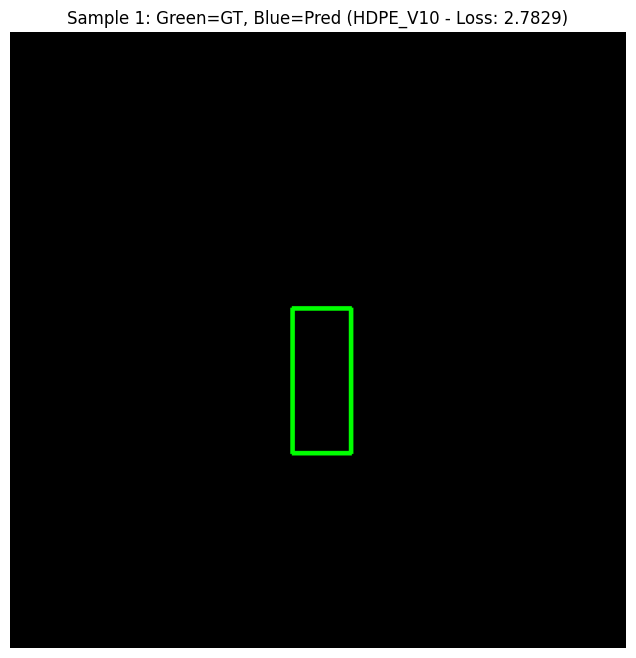

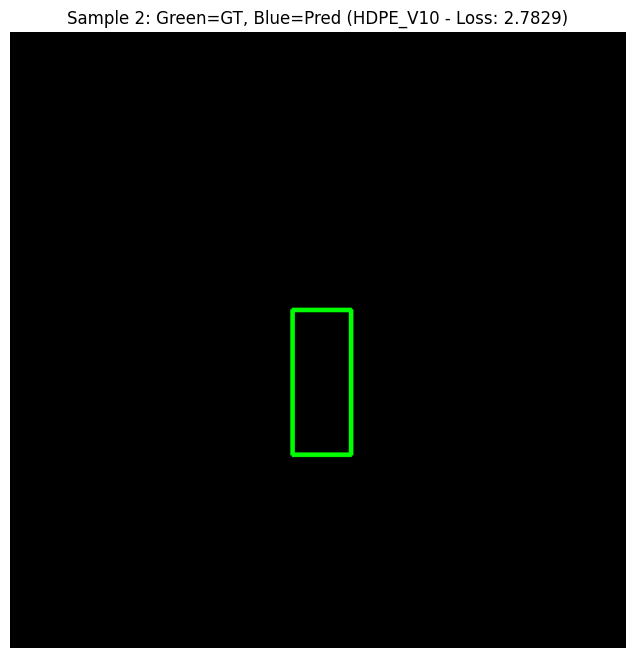

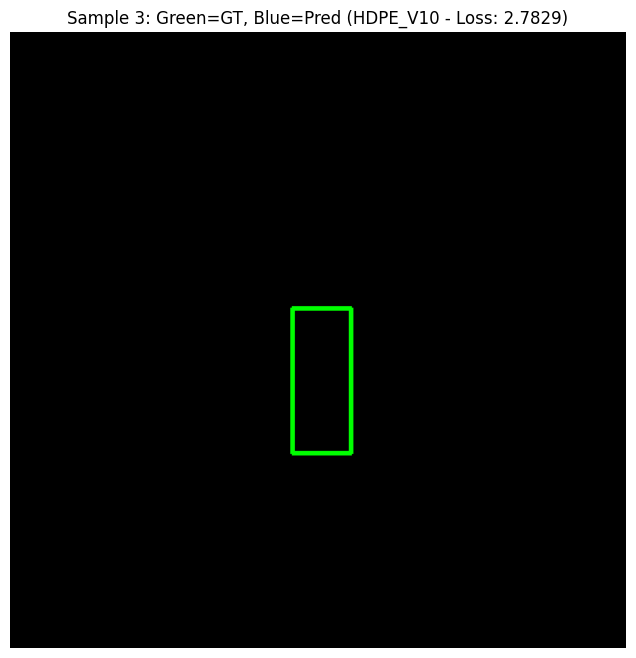

In [ ]:
# ==============================================================================
# فلفل الإنسان البصرى - نموذج HDPE_V10 (الإصدار 50)
# ==============================================================================

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# 1. الأوالق المساعة للرسم والإنزائم
def draw_rotated_box(img, cx_m, cy_m, w_m, l_m, yaw, grid_conf, color, thickness=2):
    """رسم الصنائم بناءق على الإحدائى المرجعى لإضفاء الدقة ومنع ظهورها فى الزواق."""
    h_img, w_img = img.shape[:2]

    # Ensure all metric values are Python floats before calculations
    cx_m = float(cx_m)
    cy_m = float(cy_m)
    w_m = float(w_m)
    l_m = float(l_m)
    yaw = float(yaw)

    cx_px = (cx_m - grid_conf['x_min']) / (grid_conf['x_max'] - grid_conf['x_min']) * w_img
    cy_px_raw = (cy_m - grid_conf['y_min']) / (grid_conf['y_max'] - grid_conf['y_min']) * h_img
    cy_px = h_img - cy_px_raw # قلب المحور Y لضبط منظور عمران الطلائع
    w_px = w_m / (grid_conf['x_max'] - grid_conf['x_min']) * w_img
    l_px = l_m / (grid_conf['y_max'] - grid_conf['y_min']) * h_img
    rect = ((cx_px, cy_px), (w_px, l_px), -np.degrees(yaw))
    box_points = cv2.boxPoints(rect).astype(np.int32)
    cv2.polylines(img, [box_points], True, color, thickness)

def run_nms_and_visualize(model, data_loader, device, config, num_samples=3):
    """تنفيذ الاستنجاء النهائى وعرض النتائج بصرياك لإطلاق القدرة على الانضمام."""
    model.eval() # تفعيل وضع الاستنجاء
    grid_conf = config['grid_conf']

    # جلب عملاء من البنائم
    batch = next(iter(data_loader))
    inputs = {k: v.to(device) for k, v in batch.items() if isinstance(v, torch.Tensor)}

    with torch.no_grad(): # إيقاف حساب التدرجات لتوفير الزمن
        outputs = model(inputs)
        pred_traffic = outputs[0] if isinstance(outputs, tuple) else outputs['traffic']
        pred_traffic_map = pred_traffic.cpu().view(-1, grid_conf['h'], grid_conf['w'], 7)

    gt_traffic_map = batch['gt_traffic_map'].cpu()

    for i in range(min(num_samples, gt_traffic_map.shape[0])):
        bev_img = np.zeros((400, 400, 3), dtype=np.uint8)

        # رسم الأحدائم المطلوبة (أخضر)
        mask_gt = gt_traffic_map[i, ..., 0] > 0.5
        for r, c in mask_gt.nonzero():
            feat = gt_traffic_map[i, r, c]
            cx_m = c * grid_conf['x_res'] + grid_conf['x_min'] + feat[2].item()
            cy_m = r * grid_conf['y_res'] + grid_conf['y_min'] + feat[1].item()
            w_m = feat[3].item()
            l_m = feat[4].item()
            yaw = np.arctan2(feat[5].item(), feat[6].item())
            draw_rotated_box(bev_img, cx_m, cy_m, w_m, l_m, yaw, grid_conf, (0, 255, 0))

        # تطبيق NMS ورسم التنبؤات (أزرق)
        final_boxes = non_max_suppression(pred_traffic_map[i], grid_conf, conf_thresh=0.3)
        for b in final_boxes:
            cx_m = (b['box'][0] + b['box'][2]) / 2
            cy_m = (b['box'][1] + b['box'][3]) / 2
            draw_rotated_box(bev_img, cx_m, cy_m, b['dims'][0], b['dims'][1], b['yaw'], grid_conf, (255, 100, 0), 2)

        plt.figure(figsize=(8, 8))
        plt.imshow(bev_img)
        plt.title(f"Sample {i+1}: Green=GT, Blue=Pred (HDPE_V10 - Loss: {checkpoint.get('best_val_loss', 'N/A'):.4f})")
        plt.axis('off')
        plt.show()

# 2. تحميل الأوزائم والتشريع
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CHECKPOINT_PATH = "/content/drive/MyDrive/Interfuser_traffic/HDPE_V10/best_model.pth"

# تحميل الحالة
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"✅ تم تحميل النموذج بنجائ من الإصدار {checkpoint['epoch']} بـ Validation Loss: {checkpoint.get('best_val_loss', 'N/A'):.4f}")

# --- Add definition of dataset_for_viz here ---
grid_conf = config_dict['grid_conf']
model_conf = config_dict['model_params']
transform_conf = config_dict['transforms']

TARGET_ROUTE_PATH = "/content/PDM_Lite_Carla/Town01/data/ControlLoss/Route3_Rep0"

dataset_for_viz = PDMDataset(
    data_root=str(TARGET_ROUTE_PATH),
    with_lidar=model_conf['with_lidar'],
    use_augmented=transform_conf['use_data_augmentation'],
    traffic_grid_cells=(grid_conf['w'], grid_conf['h']),
    traffic_grid_size_meters=(grid_conf['x_max'] - grid_conf['x_min'], grid_conf['y_max'] - grid_conf['y_min'])
)
print(f"✅ تم إنشاء Dataset للتحليل من: {TARGET_ROUTE_PATH} ({len(dataset_for_viz)} إطار)")

# إنشاء المحمل وتشريع العرض
viz_loader = DataLoader(dataset_for_viz, batch_size=5, shuffle=True)
run_nms_and_visualize(model, viz_loader, device, config_dict, num_samples=3)


In [ ]:
# import torch
# import torch.nn as nn
# import numpy as np
# import cv2
# import matplotlib.pyplot as plt
# from torch.utils.data import DataLoader
# from pathlib import Path

# # ==============================================================================
# #                 القسم 1: كلاس محلل الانتباه (Attention Analyzer)
# # ==============================================================================

# class AttentionMapExtractor:
#     """
#     كلاس متخصص لاستخراج وتصور خرائط الانتباه من طبقات المحول.
#     يستخدم الخطافات (Hooks) لالتقاط أوزان الانتباه أثناء تمرير البيانات.
#     """
#     def __init__(self, model, target_layer_name):
#         """
#         التهيئة.

#         Args:
#             model (nn.Module): النموذج المدرب.
#             target_layer_name (str): اسم طبقة الانتباه التي نريد استهدافها.
#                                      مثال: "decoder.layers.5.self_attn"
#         """
#         self.model = model
#         self.target_layer_name = target_layer_name
#         self.attention_weights = None

#         # البحث عن الطبقة المستهدفة وتسجيل الخطاف عليها
#         self._register_hook()

#     def _hook_fn(self, module, input, output):
#         """
#         دالة الخطاف التي سيتم تنفيذها.
#         'output' لطبقة الانتباه عادة ما يكون tuple يحتوي على:
#         (قيم الخرج, أوزان الانتباه)
#         """
#         # output[1] هو عادةً مصفوفة أوزان الانتباه
#         # قد تحتاج لتعديل هذا الرقم (1) بناءً على كيفية إرجاع طبقة الانتباه للقيم في نموذجك
#         if isinstance(output, tuple) and len(output) > 1:
#             self.attention_weights = output[1].detach().cpu()
#         else:
#             # إذا لم تكن tuple، قد تكون هي الخرج مباشرة (أقل شيوعًا)
#             self.attention_weights = output.detach().cpu()

#     def _register_hook(self):
#         """
#         يبحث عن الطبقة المستهدفة بالاسم ويسجل الخطاف.
#         """
#         target_module = None
#         for name, module in self.model.named_modules():
#             if name == self.target_layer_name:
#                 target_module = module
#                 break

#         if target_module is None:
#             raise ValueError(f"لم يتم العثور على الطبقة بالاسم: '{self.target_layer_name}'")

#         print(f"✅ تم تسجيل الخطاف بنجاح على الطبقة: {self.target_layer_name}")
#         self.handle = target_module.register_forward_hook(self._hook_fn)

#     def extract(self, inputs):
#         """
#         يمرر المدخلات عبر النموذج ويستخرج خريطة الانتباه.

#         Args:
#             inputs (dict): قاموس يحتوي على بيانات الإدخال للنموذج.

#         Returns:
#             torch.Tensor or None: مصفوفة أوزان الانتباه التي تم التقاطها.
#         """
#         self.model.eval()
#         with torch.no_grad():
#             _ = self.model(inputs) # نقوم بتمرير البيانات لتفعيل الخطاف

#         # إزالة الخطاف بعد الاستخدام لتنظيف الموارد
#         self.handle.remove()
#         print("ℹ️ تم إزالة الخطاف.")

#         return self.attention_weights

# def process_and_visualize_attention(attention_map, input_image, downsample_ratio=16):
#     """
#     تعالج خريطة الانتباه وترسمها فوق الصورة الأصلية.

#     Args:
#         attention_map (torch.Tensor): مصفوفة الانتباه الخام (عادةً [batch, num_heads, seq_len, seq_len]).
#         input_image (np.ndarray): الصورة الأصلية (بتنسيق HWC, BGR).
#         downsample_ratio (int): نسبة التصغير التي يطبقها الـ backbone على الصورة.
#                                   (e.g., ResNet يطبق 32x, لكن Interfuser قد يستخدم 16x).
#     """
#     if attention_map is None:
#         print("❌ لم يتم التقاط خريطة الانتباه.")
#         return

#     # 1. معالجة مصفوفة الانتباه
#     # افترض أننا نريد الانتباه من رمز CLS (أو رمز الاستعلام العام) إلى بقية الصورة
#     # عادة ما يكون هذا هو الصف الأول من مصفوفة الانتباه
#     # [batch, num_heads, seq_len, seq_len] -> [batch, num_heads, seq_len]
#     attn_to_process = attention_map[0, :, 0, 1:] # تجاهل الانتباه إلى النفس (CLS -> CLS)

#     # حساب متوسط الانتباه عبر جميع الرؤوس (heads)
#     # [num_heads, seq_len-1] -> [seq_len-1]
#     attn_to_process = attn_to_process.mean(dim=0)

#     # 2. إعادة تشكيل الانتباه ليطابق أبعاد الصورة المصغرة
#     h_feat = input_image.shape[0] // downsample_ratio
#     w_feat = input_image.shape[1] // downsample_ratio

#     # تأكد من أن عدد عناصر الانتباه يطابق حجم خريطة الميزات
#     if attn_to_process.shape[0] != h_feat * w_feat:
#         raise ValueError(f"حجم الانتباه ({attn_to_process.shape[0]}) لا يطابق حجم خريطة الميزات المتوقع ({h_feat*w_feat}). " \
#                          f"يرجى التحقق من 'downsample_ratio' أو منطق استخلاص الانتباه.")

#     attention_grid = attn_to_process.reshape(h_feat, w_feat).numpy()

#     # 3. تكبير خريطة الانتباه لتطابق حجم الصورة الأصلية
#     h_img, w_img = input_image.shape[:2]
#     attention_resized = cv2.resize(attention_grid, (w_img, h_img), interpolation=cv2.INTER_CUBIC)

#     # 4. تطبيع ورسم الخريطة الحرارية
#     attention_normalized = (attention_resized - attention_resized.min()) / (attention_resized.max() - attention_resized.min())
#     attention_heatmap = cv2.applyColorMap(np.uint8(255 * attention_normalized), cv2.COLORMAP_JET)

#     # 5. دمج الصورة الأصلية مع الخريطة الحرارية
#     overlayed_image = cv2.addWeighted(input_image, 0.6, attention_heatmap, 0.4, 0)

#     return overlayed_image, attention_heatmap

# # ==============================================================================
# #                      القسم 2: السكربت الرئيسي للتشغيل
# # ==============================================================================

# if __name__ == '__main__':
#     # --- 1. الإعدادات والتهيئة ---
#     # !! عليك تعديل هذه القيم لتناسب مشروعك !!
#     BASE_MODEL_PATH = "مسار/إلى/النموذج/الأساسي.pth"
#     HDPE_MODEL_PATH = "مسار/إلى/نموذج/HDPE.pth"
#     TARGET_LAYER = "decoder.layers.5.self_attn" # <--- !! عدّل هذا الاسم بدقة !!
#     DATA_PATH = "/content/PDM_Lite_Carla/Town01/data/..." # مسار لعينة بيانات واحدة أو أكثر
#     DOWNSAMPLE_RATIO = 16 # <--- !! تأكد من هذه القيمة !!

#     # تحميل الإعدادات (افترض وجود دالة get_config)
#     try:
#         config = get_config()
#         device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     except NameError:
#         print("❌ خطأ: تأكد من أن دالة 'get_config' معرفة ومتاحة.")
#         exit()

#     # --- 2. تحميل البيانات ---
#     try:
#         # نحن نحتاج عينة واحدة فقط للتصور
#         dataset = PDMDataset(data_root=DATA_PATH, config=config)
#         data_loader = DataLoader(dataset, batch_size=1, shuffle=False)
#         sample_batch = next(iter(data_loader))
#         inputs = {k: v.to(device) for k, v in sample_batch.items() if isinstance(v, torch.Tensor)}

#         # استخراج الصورة الأصلية للتصور (افترض أنها RGB)
#         # قد تحتاج لتعديل هذا بناءً على كيفية تخزين البيانات في الـ Dataset الخاص بك
#         # افترض أن الصورة هي 'rgb' ومخزنة كـ [B, C, H, W]
#         original_image_tensor = sample_batch['rgb'][0]
#         original_image_np = original_image_tensor.permute(1, 2, 0).numpy()
#         original_image_np = (original_image_np * 255).astype(np.uint8)
#         # تحويل من RGB إلى BGR لأن OpenCV يستخدم BGR
#         original_image_bgr = cv2.cvtColor(original_image_np, cv2.COLOR_RGB2BGR)

#     except (NameError, StopIteration) as e:
#         print(f"❌ خطأ في تحميل البيانات: {e}. تأكد من أن 'PDMDataset' معرفة وأن المسار صحيح.")
#         exit()

#     # --- 3. استخراج الانتباه من النموذجين ---
#     models_to_analyze = {
#         "النموذج الأساسي (Sine PE)": BASE_MODEL_PATH,
#         "نموذجنا (HDPE)": HDPE_MODEL_PATH,
#     }

#     results = {}

#     for model_name, model_path in models_to_analyze.items():
#         print(f"\n--- جاري تحليل: {model_name} ---")
#         try:
#             model = load_and_prepare_model(config, device) # افترض وجود هذه الدالة
#             model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])

#             # إنشاء محلل الانتباه واستخراج الخريطة
#             extractor = AttentionMapExtractor(model, TARGET_LAYER)
#             attention_map = extractor.extract(inputs)

#             # معالجة وتصور
#             overlay, heatmap = process_and_visualize_attention(
#                 attention_map,
#                 original_image_bgr.copy(),
#                 downsample_ratio=DOWNSAMPLE_RATIO
#             )
#             results[model_name] = (overlay, heatmap)

#         except Exception as e:
#             print(f"🔴 حدث خطأ أثناء تحليل {model_name}: {e}")
#             results[model_name] = (None, None)

#     # --- 4. عرض النتائج النهائية ---
#     fig, axes = plt.subplots(2, 2, figsize=(16, 16))
#     fig.suptitle("مقارنة خرائط الانتباه: تأثير HDPE", fontsize=20)

#     # عرض نتائج النموذج الأساسي
#     base_overlay, base_heatmap = results.get("النموذج الأساسي (Sine PE)", (None, None))
#     if base_overlay is not None:
#         axes[0, 0].imshow(cv2.cvtColor(base_heatmap, cv2.COLOR_BGR2RGB))
#         axes[0, 0].set_title("خريطة الانتباه الحرارية (النموذج الأساسي)")
#         axes[0, 1].imshow(cv2.cvtColor(base_overlay, cv2.COLOR_BGR2RGB))
#         axes[0, 1].set_title("الانتباه فوق الصورة (النموذج الأساسي)")
#     else:
#         axes[0, 0].text(0.5, 0.5, 'فشل التحليل', ha='center', va='center')
#         axes[0, 1].text(0.5, 0.5, 'فشل التحليل', ha='center', va='center')

#     # عرض نتائج نموذج HDPE
#     hdpe_overlay, hdpe_heatmap = results.get("نموذجنا (HDPE)", (None, None))
#     if hdpe_overlay is not None:
#         axes[1, 0].imshow(cv2.cvtColor(hdpe_heatmap, cv2.COLOR_BGR2RGB))
#         axes[1, 0].set_title("خريطة الانتباه الحرارية (HDPE)")
#         axes[1, 1].imshow(cv2.cvtColor(hdpe_overlay, cv2.COLOR_BGR2RGB))
#         axes[1, 1].set_title("الانتباه فوق الصورة (HDPE)")
#     else:
#         axes[1, 0].text(0.5, 0.5, 'فشل التحليل', ha='center', va='center')
#         axes[1, 1].text(0.5, 0.5, 'فشل التحليل', ha='center', va='center')

#     for ax_row in axes:
#         for ax in ax_row:
#             ax.axis('off')

#     plt.tight_layout(rect=[0, 0, 1, 0.96])
#     plt.show()